# Telangana Crop Health Challenge
---
###  Can you predict the health status of crops?
---



# Setup Notebook

In [15]:
# %%capture
# !pip install earthengine-api geopandas rasterio rasterstats shapely

In [17]:
# pip install scikit-image

   ---------------------------------------- 0.0/12.9 MB ? eta -:--:--
   ---------------------------------------- 0.0/12.9 MB 2.0 MB/s eta 0:00:07
    --------------------------------------- 0.2/12.9 MB 2.1 MB/s eta 0:00:07
   - -------------------------------------- 0.3/12.9 MB 2.6 MB/s eta 0:00:05
   - -------------------------------------- 0.6/12.9 MB 3.5 MB/s eta 0:00:04
   -- ------------------------------------- 0.8/12.9 MB 3.7 MB/s eta 0:00:04
   --- ------------------------------------ 1.1/12.9 MB 4.2 MB/s eta 0:00:03
   ---- ----------------------------------- 1.3/12.9 MB 4.3 MB/s eta 0:00:03
   ---- ----------------------------------- 1.5/12.9 MB 4.4 MB/s eta 0:00:03
   ----- ---------------------------------- 1.9/12.9 MB 4.6 MB/s eta 0:00:03
   ------ --------------------------------- 2.1/12.9 MB 4.7 MB/s eta 0:00:03
   ------- -------------------------------- 2.4/12.9 MB 4.7 MB/s eta 0:00:03
   -------- ------------------------------- 2.6/12.9 MB 4.7 MB/s eta 0:00:03
   ---


[notice] A new release of pip is available: 24.0 -> 25.0
[notice] To update, run: python.exe -m pip install --upgrade pip


# Libraries and Modules Import

In [1]:
# Standard Library Imports
from concurrent.futures import ThreadPoolExecutor, as_completed
from joblib import Parallel, delayed
from tqdm import tqdm
from datetime import datetime
from pathlib import Path
import os
import random

# Third-Party Imports
# import ee
# import geemap
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import rasterio
from lightgbm import LGBMClassifier
from shapely.affinity import scale, translate
from skimage import exposure
from sklearn.metrics import classification_report, f1_score
from sklearn.model_selection import StratifiedKFold, train_test_split
from sklearn.preprocessing import LabelEncoder

from shapely import wkt
import geopandas as gpd

import warnings
warnings.filterwarnings('ignore')

import logging
# Set up a logger to capture Rasterio warnings
logging.getLogger("rasterio._env").setLevel(logging.ERROR)

# Project Setup and Earth Engine Initialization

In [2]:
# Define the root path for the project
root_path = Path("")

# Data Loading and Preprocessing

**Load Train and Test**

In [3]:
# Load training and testing datasets from CSV files
train = pd.read_csv(root_path / 'Train.csv')
test = pd.read_csv(root_path / 'Test.csv')

**Convert Geometry Columns to Geospatial Format**

In [4]:
# Convert WKT geometry to actual geometry objects in both datasets
train['geometry'] = train['geometry'].apply(wkt.loads)
test['geometry'] = test['geometry'].apply(wkt.loads)

**Convert DataFrames to GeoDataFrames**

In [5]:
# Convert pandas DataFrames to GeoDataFrames with CRS set to 'epsg:4326'
train = gpd.GeoDataFrame(train, crs='epsg:4326')
test = gpd.GeoDataFrame(test, crs='epsg:4326')

**Concatenate Train and Test Data for Unified Processing**

In [6]:
# Concatenate train and test datasets into a single DataFrame for consistent processing
# 'dataset' column distinguishes between train and test rows
data = pd.concat(
    [train.assign(dataset='train'), test.assign(dataset='test')]
).reset_index(drop=True)


**Scale Geometry Objects**

In [7]:
# Function to scale each geometry around its centroid
def scale_geometry(geometry, scale_factor):
    """
    Scale a geometry object around its centroid.

    Parameters:
        geometry (shapely.geometry.base.BaseGeometry): Geometry to scale.
        scale_factor (float): Factor by which to scale the geometry.

    Returns:
        shapely.geometry.base.BaseGeometry: Scaled geometry object.
    """
    # Calculate centroid
    centroid = geometry.centroid
    # Translate geometry to origin
    translated_geometry = translate(geometry, -centroid.x, -centroid.y)
    # Scale geometry
    scaled_geometry = scale(translated_geometry, xfact=scale_factor, yfact=scale_factor, origin=(0, 0))
    # Translate back to the original centroid
    return translate(scaled_geometry, centroid.x, centroid.y)

In [8]:
# Set the scaling factor
scale_factor = 5

# Apply the scaling function to each geometry in the data
# This modifies each geometry in place by the defined scale factor
data['geometry'] = data['geometry'].apply(scale_geometry, scale_factor=scale_factor)

## Download Image Data

**Utils**

In [9]:
# Function to ensure date format is correct
def format_date(date_str):
    """Convert date string to 'YYYY-MM-DD' format."""
    try:
        return datetime.strptime(date_str, '%d-%m-%Y').strftime('%Y-%m-%d')
    except ValueError:
        print(f"Error: Invalid date format for {date_str}. Expected 'DD-MM-YYYY'.")
        return None

In [10]:
# Function to process each row in the dataset for image download
def process_row(index, row):
    # Format start and end dates
    start_date = format_date(row['SDate'])
    end_date = format_date(row['HDate'])

    # Skip rows with invalid dates
    if not start_date or not end_date:
        print(f"Skipping entry due to invalid dates: SDate={row['SDate']}, HDate={row['HDate']}")
        return index, None

    # Extract and check geometry
    region_geometry = row['geometry']
    district = row['District']

    # Verify valid geometry and convert it to EE format
    if region_geometry.is_empty:
        print(f"Skipping entry due to empty geometry for District: {district}")
        return index, None

    # Convert geometry type to EE compatible format
    if region_geometry.geom_type == 'Polygon':
        region = ee.Geometry.Polygon(region_geometry.__geo_interface__['coordinates'])
    elif region_geometry.geom_type == 'MultiPolygon':
        coords = [polygon.exterior.coords[:] for polygon in region_geometry.geoms]
        region = ee.Geometry.MultiPolygon(coords)
    else:
        print(f"Skipping unsupported geometry type: {region_geometry.geom_type} for District: {district}")
        return index, None

    # Define Sentinel-2 collection and bands
    image_collection_name = 'COPERNICUS/S2'
    bands = ['B4', 'B3', 'B2', 'B8', 'B5', 'B6', 'B7', 'B8A', 'B11', 'B12']

    # Attempt to download the image
    try:
        image_file = download_rgb_image(image_collection_name, bands, start_date, end_date, region, output_folder)
        return index, image_file
    except Exception as e:
        print(f"Error processing entry for District {district}: {e}")
        return index, None

- Run this code to load the data, then use the appearing path to locate it

In [ ]:
import kagglehub

# Download latest version
path = kagglehub.dataset_download("muhammadqasimshabbir/sentineltimeseriesdata")

print("Path to dataset files:", path)

In [11]:
# Load existing data with image paths if downloads are not required
PATH_DATA = rf'{path}\SentinelTimeSeriesData'
data_path = PATH_DATA + '\Data.csv'
data = pd.read_csv(data_path)

In [12]:
data.head()

,FarmID,category,Crop,State,District,Sub-District,SDate,HDate,CropCoveredArea,CHeight,...,CTransp,IrriType,IrriSource,IrriCount,WaterCov,ExpYield,Season,geometry,dataset,tif_path
0,1326576,Healthy,Paddy,Telangana,Medak,Kulcharam,25-11-2023,14-04-2024,97,54,...,Transplanting,Flood,Groundwater,4,87,17,Rabi,POLYGON ((78.18079255482755 17.978971746424413...,train,/kaggle/input/sentineltimeseriesdata/SentinelT...
1,1326577,Healthy,Paddy,Telangana,Medak,Kulcharam,13-11-2023,26-04-2024,82,58,...,Transplanting,Flood,Canal,5,94,15,Rabi,POLYGON ((78.17483419891283 17.981508840879556...,train,/kaggle/input/sentineltimeseriesdata/SentinelT...
2,1326578,Healthy,Paddy,Telangana,Medak,Kulcharam,19-12-2023,28-04-2024,92,91,...,Transplanting,Flood,Canal,3,99,20,Rabi,POLYGON ((78.16888476438905 17.976727511659835...,train,/kaggle/input/sentineltimeseriesdata/SentinelT...
3,1331836,Diseased,Paddy,Telangana,Medak,Kulcharam,11-02-2023,04-11-2024,91,52,...,Transplanting,Flood,Canal,5,92,16,Rabi,POLYGON ((78.16821795882959 17.974690113471414...,train,/kaggle/input/sentineltimeseriesdata/SentinelT...
4,1326579,Diseased,Paddy,Telangana,Medak,Kulcharam,12-12-2023,19-05-2024,94,55,...,Transplanting,Flood,Canal,5,97,20,Rabi,POLYGON ((78.17244459940454 17.969620948965225...,train,/kaggle/input/sentineltimeseriesdata/SentinelT...


# Data Analysis

In [13]:
data.isna().sum().sort_values()

FarmID                0
geometry              0
Season                0
ExpYield              0
WaterCov              0
IrriCount             0
IrriSource            0
IrriType              0
CTransp               0
CLast                 0
CNext                 0
CHeight               0
CropCoveredArea       0
HDate                 0
SDate                 0
Sub-District          0
District              0
State                 0
Crop                  0
dataset               0
tif_path           1196
category           3016
dtype: int64

## Check multi Corr

<Axes: >

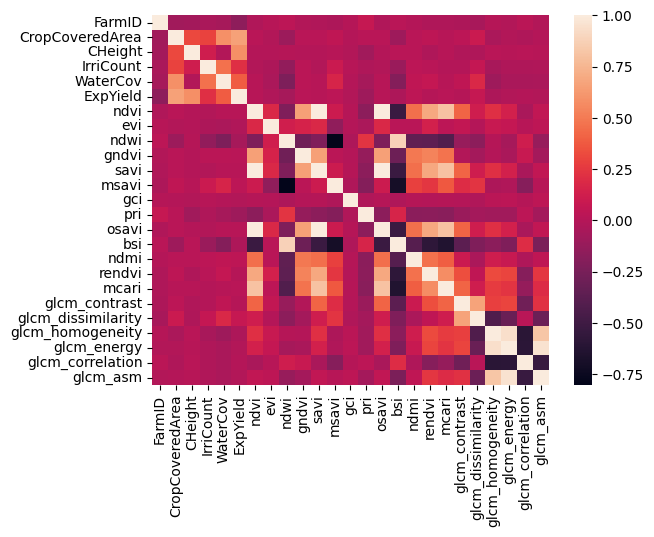

In [ ]:
import seaborn as sns
sns.heatmap(data.select_dtypes('number').corr())

In [ ]:
data.select_dtypes('number').corr()

,FarmID,CropCoveredArea,CHeight,IrriCount,WaterCov,ExpYield,ndvi,evi,ndwi,gndvi,...,bsi,ndmi,rendvi,mcari,glcm_contrast,glcm_dissimilarity,glcm_homogeneity,glcm_energy,glcm_correlation,glcm_asm
FarmID,1.000000,-0.077739,-0.072700,-0.047447,-0.058198,-0.155239,-0.015523,0.013087,0.031662,-0.012394,...,0.019723,-0.005968,-0.026979,-0.025256,-0.032075,-0.051494,0.002057,-0.011931,0.022688,-0.012307
CropCoveredArea,-0.077739,1.000000,0.316362,0.291978,0.589567,0.659212,0.016263,-0.011618,-0.101057,0.019419,...,-0.095498,0.020100,0.036021,0.009848,0.031368,0.096606,-0.037538,-0.006971,-0.024239,-0.005226
CHeight,-0.072700,0.316362,1.000000,0.117583,-0.007512,0.583791,-0.003439,0.000081,0.003172,-0.000653,...,0.020196,0.015954,-0.024609,0.012725,-0.016480,-0.021384,0.017287,0.010770,0.014849,0.010271
IrriCount,-0.047447,0.291978,0.117583,1.000000,0.458527,0.216943,-0.006895,-0.028276,-0.144099,0.023961,...,-0.107485,0.035815,0.019107,0.000389,-0.001762,0.068341,-0.053009,-0.024419,-0.023636,-0.015082
WaterCov,-0.058198,0.589567,-0.007512,0.458527,1.000000,0.386395,0.007939,-0.039265,-0.230948,0.022032,...,-0.198642,0.047364,0.070017,0.012759,0.045464,0.180186,-0.096195,-0.044418,-0.047761,-0.037279
ExpYield,-0.155239,0.659212,0.583791,0.216943,0.386395,1.000000,0.010007,-0.013515,-0.060646,0.019131,...,-0.034020,0.038846,0.005911,0.019627,0.006032,0.073167,-0.034401,-0.010763,-0.002312,-0.012830
ndvi,-0.015523,0.016263,-0.003439,-0.006895,0.007939,0.010007,1.000000,0.183018,-0.217597,0.651114,...,-0.521359,0.457333,0.689696,0.806712,0.412474,0.116231,0.216739,0.137118,-0.044447,0.053966
evi,0.013087,-0.011618,0.000081,-0.028276,-0.039265,-0.013515,0.183018,1.000000,0.123579,0.151820,...,0.020729,0.019892,0.140454,0.030888,0.062343,-0.005389,0.082846,0.069149,0.011590,0.040859
ndwi,0.031662,-0.101057,0.003172,-0.144099,-0.230948,-0.060646,-0.217597,0.123579,1.000000,-0.286432,...,0.875777,-0.353956,-0.358293,-0.417208,-0.124392,-0.161672,0.005168,-0.060243,0.118992,-0.121530
gndvi,-0.012394,0.019419,-0.000653,0.023961,0.022032,0.019131,0.651114,0.151820,-0.286432,1.000000,...,-0.297292,0.489413,0.531634,0.465768,-0.008678,-0.067706,0.000665,-0.046491,0.080225,-0.064275


In [ ]:
import numpy as np

# Compute correlation matrix
corr_matrix = data.select_dtypes(include=['number']).corr().abs()

# Define correlation threshold
threshold = 0.9

# Find highly correlated features
upper = corr_matrix.where(np.triu(np.ones(corr_matrix.shape), k=1).astype(bool))
to_drop = [column for column in upper.columns if any(upper[column] > threshold)]

# Drop correlated features
data_reduced = data.drop(columns=to_drop)

print(f"Removed {len(to_drop)} highly correlated features: {to_drop}")


Removed 4 highly correlated features: ['savi', 'osavi', 'glcm_energy', 'glcm_asm']


## Check Skewness

In [ ]:
from scipy.stats import skew
import numpy as np

# Select numerical features
num_features = data.select_dtypes(include=['number'])

# Compute skewness
skewness = num_features.apply(skew).sort_values(ascending=False)

# Define skewness threshold (greater than 0.75 is considered highly skewed)
skew_threshold = 0.75
highly_skewed = skewness[skewness > skew_threshold]

print(f"Highly Skewed Features:\n{highly_skewed}")


Highly Skewed Features:
CHeight    1.347914
dtype: float64


In [ ]:
from scipy.special import boxcox1p

# Fix skewed features
for feature in highly_skewed.index:
    if (num_features[feature] > 0).all():  # Check if all values are positive
        data[feature] = boxcox1p(data[feature], 0.15)  # Box-Cox
    else:
        data[feature] = np.log1p(data[feature])  # Log1p for zero/negative values

print("Skewness fixed using Box-Cox or Log1p.")


Skewness fixed using Box-Cox or Log1p.


# Visualization

In [14]:
# Function to scale pixel values to the 0–255 range for better visualization
def scale_band(band):
    """
    Scales pixel values of a single band to the 0-255 range.

    Parameters:
    - band: np.array, pixel values of the band

    Returns:
    - np.array, scaled pixel values in the 0-255 range
    """
    band = band.astype(np.float32)  # Ensure values are in float for scaling
    return 255 * (band - np.min(band)) / (np.max(band) - np.min(band))  # Scale to 0–255

# Function to visualize RGB image with scaling, contrast adjustments, and optional gamma correction
def visualize_rgb_image(file_path, gamma=0.6, contrast_stretch=True):
    """
    Visualize an RGB image using matplotlib with scaling, optional gamma correction, and contrast stretching.

    Parameters:
    - file_path: str, path to the RGB image file (GeoTIFF)
    - gamma: float, gamma correction factor (default=0.6)
    - contrast_stretch: bool, whether to apply contrast stretching (default=True)
    """
    # Open the image file
    with rasterio.open(file_path) as src:
        # Read RGB bands (assuming Sentinel-2 band order: Red=B4, Green=B3, Blue=B2)
        red = src.read(3)  # Band 4 for Red
        green = src.read(2)  # Band 3 for Green
        blue = src.read(1)  # Band 2 for Blue

        # Scale each band to the 0–255 range for better visualization
        red_scaled = scale_band(red)
        green_scaled = scale_band(green)
        blue_scaled = scale_band(blue)

        # Stack the scaled RGB bands into a single image
        rgb = np.dstack((red_scaled, green_scaled, blue_scaled)).astype(np.uint8)

        # Apply contrast stretching if specified
        if contrast_stretch:
            p2, p98 = np.percentile(rgb, (2, 98))  # Calculate 2nd and 98th percentiles for stretching
            rgb = exposure.rescale_intensity(rgb, in_range=(p2, p98))

        # Apply gamma correction to adjust brightness
        rgb = exposure.adjust_gamma(rgb, gamma=gamma)

        # Display the processed image using matplotlib
        plt.figure(figsize=(5, 5))
        plt.imshow(rgb)
        plt.axis('off')  # Hide axes for a cleaner look
        plt.title("RGB Composite (Red-Green-Blue) with Scaling, Contrast Stretch, and Gamma Correction")
        plt.show()

    return rgb

In [15]:
# Replace backslashes with forward slashes in the path
y = r'C:\Users\THiNKBooK\.cache\kagglehub\datasets\muhammadqasimshabbir\sentineltimeseriesdata\versions\1\SentinelTimeSeriesData\downloads'
y = y.replace('\\', '/')

# Apply the lambda function to generate the full path
data['full_tif_path'] = data['tif_path'].apply(
    lambda x: y + '/' + x.split('/')[-1] if isinstance(x, str) else x
)


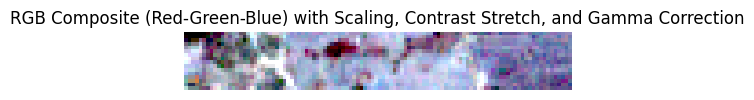

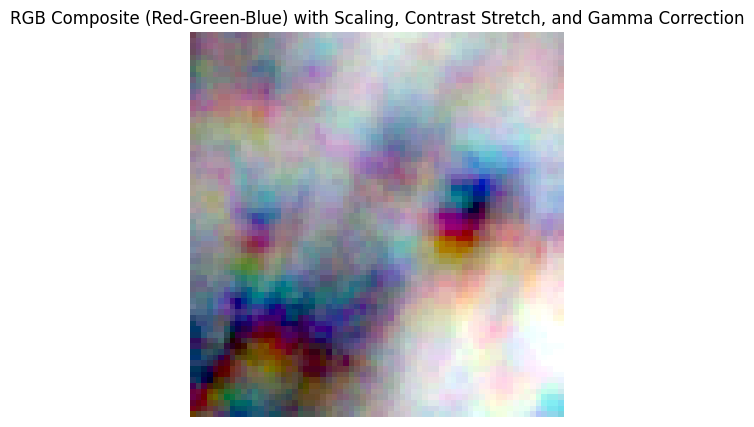

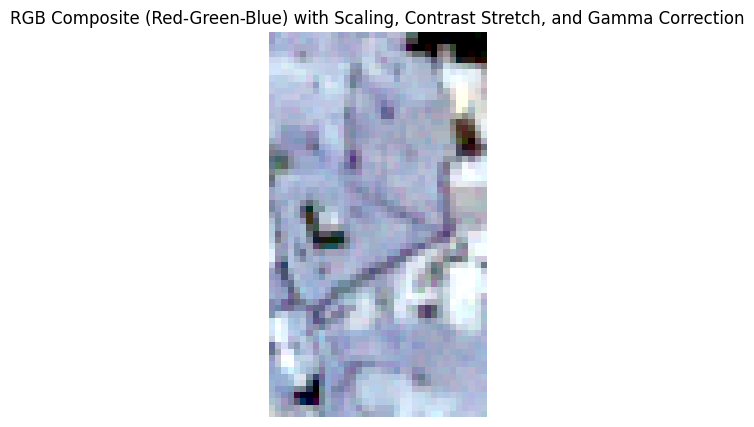

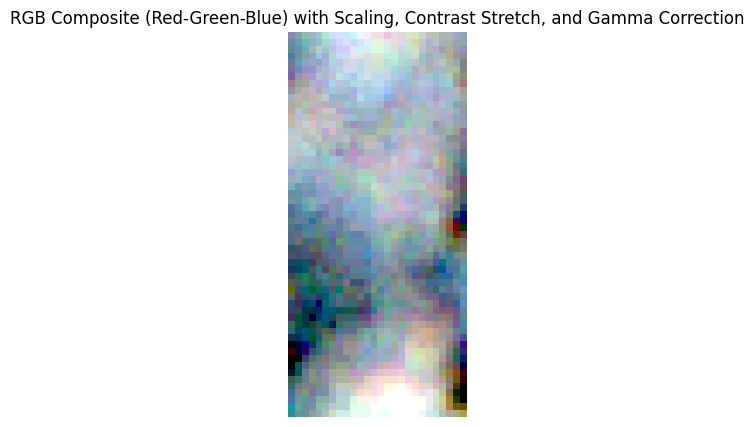

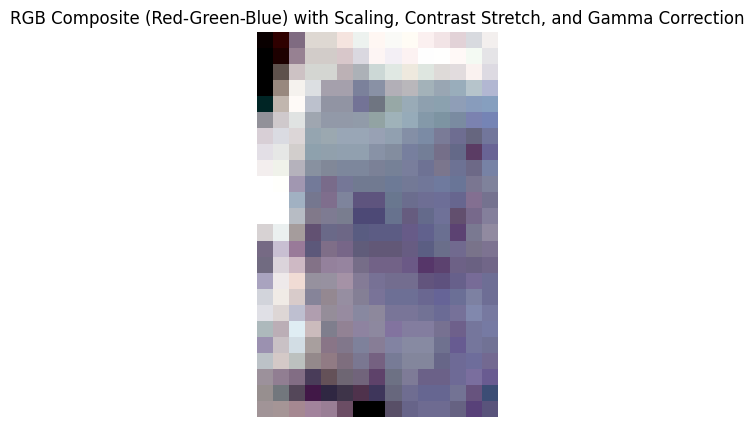

In [16]:
# Select a random image file from the dataset and visualize it
for _ in range(5):
    path = random.choice(data['full_tif_path'].values)
    if isinstance(path, str) :
        image = visualize_rgb_image(path)

# Feature Engineering

**Utils**

In [17]:
# Example feature calculation functions
def calculate_ndvi(nir_band, red_band):
    """Calculate NDVI (Normalized Difference Vegetation Index)."""
    ndvi = (nir_band - red_band) / (nir_band + red_band)
    return np.nanmean(ndvi)

def calculate_evi(nir_band, red_band, blue_band):
    """Calculate EVI (Enhanced Vegetation Index)."""
    evi = 2.5 * (nir_band - red_band) / (nir_band + 6 * red_band - 7.5 * blue_band + 1)
    return np.nanmean(evi)

def calculate_ndwi(nir_band, green_band):
    """Calculate NDWI (Normalized Difference Water Index)."""
    ndwi = (green_band - nir_band) / (green_band + nir_band)
    return np.nanmean(ndwi)

def calculate_gndvi(nir_band, green_band):
    """Calculate GNDVI (Green Normalized Difference Vegetation Index)."""
    gndvi = (nir_band - green_band) / (nir_band + green_band)
    return np.nanmean(gndvi)

def calculate_savi(nir_band, red_band, L=0.5):
    """Calculate SAVI (Soil Adjusted Vegetation Index)."""
    savi = ((nir_band - red_band) / (nir_band + red_band + L)) * (1 + L)
    return np.nanmean(savi)

def calculate_msavi(nir_band, red_band):
    """Calculate MSAVI (Modified Soil Adjusted Vegetation Index)."""
    msavi = (2 * nir_band + 1 - np.sqrt((2 * nir_band + 1)**2 - 8 * (nir_band - red_band))) / 2
    return np.nanmean(msavi)

In [18]:
def calculate_bsi(red_band, blue_band, nir_band, swir_band):
    """Calculate BSI (Bare Soil Index)."""
    bsi = ((red_band + swir_band) - (nir_band + blue_band)) / ((red_band + swir_band) + (nir_band + blue_band))
    return np.nanmean(bsi)
def calculate_gci(nir_band, green_band):
    """Calculate GCI (Green Chlorophyll Index)."""
    gci = (nir_band / green_band) - 1
    return np.nanmean(gci)
def calculate_rendvi(re_band, nir_band):
    """Calculate RENDVI (Red Edge NDVI)."""
    rendvi = (nir_band - re_band) / (nir_band + re_band)
    return np.nanmean(rendvi)


In [19]:
# Function to calculate features for each row in the data
def process_row_for_features(index, row):
    features = {'index': index}

    # Retrieve the TIFF file path and check if it's valid
    tif_path = row['tif_path']
    if not isinstance(tif_path, str):
        print(f"Skipping entry due to missing tif_path for index {index}")
        # Add NaN for all features if path is missing
        features.update({
            'ndvi': np.nan,
            'evi': np.nan,
            'ndwi': np.nan,
            'gndvi': np.nan,
            'savi': np.nan,
            'msavi': np.nan,
            'bsi': np.nan,
            'gci': np.nan,
            'rendvi': np.nan
        })
        return features

    # Open the TIFF file and read bands for feature calculation
    with rasterio.open(tif_path) as src:
        red = src.read(3)    # B4 for Red
        green = src.read(2)  # B3 for Green
        blue = src.read(1)   # B2 for Blue
        nir = src.read(4)    # B8 for NIR
        swir = src.read(5)   # B11 for SWIR (if available)
        re = src.read(6)     # B5 for Red Edge (if available)

        # Calculate each feature
        features['ndvi'] = calculate_ndvi(nir, red)
        features['evi'] = calculate_evi(nir, red, blue)
        features['ndwi'] = calculate_ndwi(nir, green)
        features['gndvi'] = calculate_gndvi(nir, green)
        features['savi'] = calculate_savi(nir, red)
        features['msavi'] = calculate_msavi(nir, red)
        features['bsi'] = calculate_bsi(red, blue, nir, swir) if 'swir' in locals() else np.nan
        features['gci'] = calculate_gci(nir, green)
        features['rendvi'] = calculate_rendvi(re, nir) if 're' in locals() else np.nan

    return features

In [20]:
import numpy as np
import rasterio
from scipy.special import boxcox1p
from scipy.stats import skew
from skimage.feature import graycomatrix, graycoprops

# ----------------------------
# Spectral Index Functions
# ----------------------------

def calculate_ndvi(nir_band, red_band):
    """Calculate NDVI (Normalized Difference Vegetation Index)."""
    ndvi = (nir_band - red_band) / (nir_band + red_band + 1e-6)
    return np.nanmean(ndvi)

def calculate_evi(nir_band, red_band, blue_band):
    """Calculate EVI (Enhanced Vegetation Index)."""
    evi = 2.5 * (nir_band - red_band) / (nir_band + 6 * red_band - 7.5 * blue_band + 1)
    return np.nanmean(evi)

def calculate_ndwi(nir_band, green_band):
    """Calculate NDWI (Normalized Difference Water IndeX_pred)."""
    ndwi = (green_band - nir_band) / (green_band + nir_band + 1e-6)
    return np.nanmean(ndwi)

def calculate_gndvi(nir_band, green_band):
    """Calculate GNDVI (Green Normalized Difference Vegetation Index)."""
    gndvi = (nir_band - green_band) / (nir_band + green_band + 1e-6)
    return np.nanmean(gndvi)

def calculate_savi(nir_band, red_band, L=0.5):
    """Calculate SAVI (Soil Adjusted Vegetation Index)."""
    savi = ((nir_band - red_band) / (nir_band + red_band + L)) * (1 + L)
    return np.nanmean(savi)

def calculate_msavi(nir_band, red_band):
    """Calculate MSAVI (Modified Soil Adjusted Vegetation Index)."""
    msavi = (2 * nir_band + 1 - np.sqrt((2 * nir_band + 1)**2 - 8 * (nir_band - red_band))) / 2
    return np.nanmean(msavi)

def calculate_bsi(red_band, blue_band, nir_band, swir_band):
    """Calculate BSI (Bare Soil Index)."""
    bsi = ((red_band + swir_band) - (nir_band + blue_band)) / ((red_band + swir_band) + (nir_band + blue_band) + 1e-6)
    return np.nanmean(bsi)

def calculate_gci(nir_band, green_band):
    """Calculate GCI (Green Chlorophyll Index)."""
    gci = (nir_band / (green_band + 1e-6)) - 1
    return np.nanmean(gci)

def calculate_rendvi(re_band, nir_band):
    """Calculate RENDVI (Red Edge NDVI)."""
    rendvi = (nir_band - re_band) / (nir_band + re_band + 1e-6)
    return np.nanmean(rendvi)

def calculate_ndmi(nir_band, swir_band):
    """Calculate NDMI (Normalized Difference Moisture Index)."""
    ndmi = (nir_band - swir_band) / (nir_band + swir_band + 1e-6)
    return np.nanmean(ndmi)

def calculate_osavi(nir_band, red_band):
    """Calculate OSAVI (Optimized Soil Adjusted Vegetation Index)."""
    osavi = (nir_band - red_band) / (nir_band + red_band + 0.16)
    return np.nanmean(osavi)

def calculate_mcari(red_edge_band, red_band, blue_band):
    """Calculate MCARI (Modified Chlorophyll Absorption in Reflectance Index). \n
       Note: MCARI is sensitive to chlorophyll content. Requires red edge band."""
    mcari = (red_edge_band - red_band) - 0.2 * (red_edge_band - blue_band)
    return np.nanmean(mcari)

def calculate_pri(green_band, blue_band):
    """Calculate PRI (Photochemical Reflectance Index). \n
       PRI is related to photosynthetic light use efficiency."""
    pri = (green_band - blue_band) / (green_band + blue_band + 1e-6)
    return np.nanmean(pri)

# ----------------------------
# Texture Feature Function
# ----------------------------
def calculate_texture_features(band, distances=[1], angles=[0], levels=256):
    """
    Calculate texture features using Gray-Level Co-occurrence Matrix (GLCM).
    Returns a dictionary with contrast, dissimilarity, homogeneity, energy, correlation, and ASM.
    """
    # Replace NaNs with 0, normalize the band to the range [0, levels-1]
    band = np.nan_to_num(band, nan=0)
    band_norm = (band - np.min(band)) / (np.max(band) - np.min(band) + 1e-6)
    band_scaled = (band_norm * (levels - 1)).astype('uint8')
    
    glcm = graycomatrix(band_scaled, distances=distances, angles=angles, levels=levels, symmetric=True, normed=True)
    
    features = {
        'glcm_contrast': graycoprops(glcm, 'contrast')[0, 0],
        'glcm_dissimilarity': graycoprops(glcm, 'dissimilarity')[0, 0],
        'glcm_homogeneity': graycoprops(glcm, 'homogeneity')[0, 0],
        'glcm_energy': graycoprops(glcm, 'energy')[0, 0],
        'glcm_correlation': graycoprops(glcm, 'correlation')[0, 0],
        'glcm_asm': graycoprops(glcm, 'ASM')[0, 0]
    }
    return features

# ----------------------------
# Main Processing Function
# ----------------------------
def process_row_for_features(index, row):
    """
    Calculate a suite of spectral and texture features for a given row of input data.
    This function is designed to support agricultural classification (Diseased, Pests, Stressed, Healthy)
    by extracting science-based features from multispectral TIFF imagery.
    """
    features = {'index': index}

    # Retrieve the TIFF file path and check if it's valid
    tif_path = row.get('full_tif_path')
    if not isinstance(tif_path, str):
        print(f"Skipping entry due to missing tif_path for index {indeX_NH}")
        # Add NaN for all features if path is missing
        features.update({
            'ndvi': np.nan, 'evi': np.nan, 'ndwi': np.nan, 'gndvi': np.nan,
            'savi': np.nan, 'msavi': np.nan, 'bsi': np.nan, 'gci': np.nan,
            'rendvi': np.nan, 'ndmi': np.nan, 'osavi': np.nan, 'mcari': np.nan,
            'pri': np.nan
        })
        # Optionally add placeholder teX_NHture features
        for key in ['glcm_contrast', 'glcm_dissimilarity', 'glcm_homogeneity', 
                    'glcm_energy', 'glcm_correlation', 'glcm_asm']:
            features[key] = np.nan
        return features

    # Open the TIFF file and read bands for feature calculation
    with rasterio.open(tif_path) as src:
        # Read bands; the exact band order may differ by sensor
        # For example purposes, we assume:
        # Band 1: Blue, Band 2: Green, Band 3: Red, Band 4: NIR, 
        # Band 5: SWIR, Band 6: Red Edge (if available)
        try:
            blue = src.read(1)
            green = src.read(2)
            red = src.read(3)
            nir = src.read(4)
        except Exception as e:
            print(f"Error reading mandatory bands for index {index}: {e}")
            return features

        # Attempt to read additional bands if available
        try:
            swir = src.read(5)
        except Exception:
            swir = None

        try:
            red_edge = src.read(6)
        except Exception:
            red_edge = None

        # Calculate spectral indices (basic and advanced)
        features['ndvi'] = calculate_ndvi(nir, red)
        features['evi'] = calculate_evi(nir, red, blue)
        features['ndwi'] = calculate_ndwi(nir, green)
        features['gndvi'] = calculate_gndvi(nir, green)
        features['savi'] = calculate_savi(nir, red)
        features['msavi'] = calculate_msavi(nir, red)
        features['gci'] = calculate_gci(nir, green)
        features['pri'] = calculate_pri(green, blue)
        features['osavi'] = calculate_osavi(nir, red)
        
        if swir is not None:
            features['bsi'] = calculate_bsi(red, blue, nir, swir)
            features['ndmi'] = calculate_ndmi(nir, swir)
        else:
            features['bsi'] = np.nan
            features['ndmi'] = np.nan

        if red_edge is not None:
            features['rendvi'] = calculate_rendvi(red_edge, nir)
            features['mcari'] = calculate_mcari(red_edge, red, blue)
        else:
            features['rendvi'] = np.nan
            features['mcari'] = np.nan

        # ----------------------------
        # Texture Feature Extraction
        # ----------------------------
        # Example: Compute texture features on the NDVI image.
        # You can also compute texture features on any band (or combination) that is relevant.
        # Here we create a temporary NDVI image.
        ndvi_image = (nir - red) / (nir + red + 1e-6)
        texture_feats = calculate_texture_features(ndvi_image)
        features.update(texture_feats)

    return features

In [21]:
from skimage.feature import __all__
print(__all__)


['BRIEF', 'CENSURE', 'Cascade', 'ORB', 'SIFT', 'blob_dog', 'blob_doh', 'blob_log', 'canny', 'corner_fast', 'corner_foerstner', 'corner_harris', 'corner_kitchen_rosenfeld', 'corner_moravec', 'corner_orientations', 'corner_peaks', 'corner_shi_tomasi', 'corner_subpix', 'daisy', 'draw_haar_like_feature', 'draw_multiblock_lbp', 'fisher_vector', 'graycomatrix', 'graycoprops', 'haar_like_feature', 'haar_like_feature_coord', 'hessian_matrix', 'hessian_matrix_det', 'hessian_matrix_eigvals', 'hog', 'learn_gmm', 'local_binary_pattern', 'match_descriptors', 'match_template', 'multiblock_lbp', 'multiscale_basic_features', 'peak_local_max', 'plot_matched_features', 'shape_index', 'structure_tensor', 'structure_tensor_eigenvalues']


**Calculate Features**

In [22]:
# Use parallel processing to calculate features for each row
# `tqdm` provides a progress bar to track completion
new_features = Parallel(n_jobs=-1)(delayed(process_row_for_features)(index, row)
                                   for index, row in tqdm(data.iterrows(), total=len(data)))

100%|████████████████████████████████████████████████████████████████████████████| 11791/11791 [06:42<00:00, 29.32it/s]


**Merge New Features with Original Data**

In [23]:
# Convert list of features to a DataFrame and merge with the original data
new_features_df = pd.DataFrame(new_features).set_index('index')
data = data.join(new_features_df)
backup_data = data.copy()

In [24]:
data.head()

,FarmID,category,Crop,State,District,Sub-District,SDate,HDate,CropCoveredArea,CHeight,...,bsi,ndmi,rendvi,mcari,glcm_contrast,glcm_dissimilarity,glcm_homogeneity,glcm_energy,glcm_correlation,glcm_asm
0,1326576,Healthy,Paddy,Telangana,Medak,Kulcharam,25-11-2023,14-04-2024,97,54,...,4.530377,0.125265,0.568464,3932.788772,845.870370,21.796296,0.099442,0.045962,0.816874,0.002112
1,1326577,Healthy,Paddy,Telangana,Medak,Kulcharam,13-11-2023,26-04-2024,82,58,...,6.065033,0.118236,0.039324,674.886154,543.465587,16.323887,0.093640,0.049750,0.649683,0.002475
2,1326578,Healthy,Paddy,Telangana,Medak,Kulcharam,19-12-2023,28-04-2024,92,91,...,5.420150,0.131406,0.209200,864.816970,1167.146667,25.026667,0.042967,0.060000,0.715890,0.003600
3,1331836,Diseased,Paddy,Telangana,Medak,Kulcharam,11-02-2023,04-11-2024,91,52,...,5.748803,0.171215,0.098668,775.224667,1176.775439,25.028070,0.103544,0.044659,0.749821,0.001994
4,1326579,Diseased,Paddy,Telangana,Medak,Kulcharam,12-12-2023,19-05-2024,94,55,...,4.428991,0.084270,0.510771,1024.782906,1374.384615,27.384615,0.117199,0.072275,0.646116,0.005224


In [25]:
train.shape, test.shape

((7888, 20), (2718, 19))

In [26]:
data[data.FarmID.isin(train.FarmID.values)].isna().sum(), data[data.FarmID.isin(test.FarmID.values)].isna().sum()

(FarmID                0
 category              0
 Crop                  0
 State                 0
 District              0
 Sub-District          0
 SDate                 0
 HDate                 0
 CropCoveredArea       0
 CHeight               0
 CNext                 0
 CLast                 0
 CTransp               0
 IrriType              0
 IrriSource            0
 IrriCount             0
 WaterCov              0
 ExpYield              0
 Season                0
 geometry              0
 dataset               0
 tif_path              8
 full_tif_path         8
 ndvi                  8
 evi                   8
 ndwi                  8
 gndvi                 8
 savi                  8
 msavi                 8
 gci                   8
 pri                   8
 osavi                 8
 bsi                   8
 ndmi                  8
 rendvi                8
 mcari                 8
 glcm_contrast         8
 glcm_dissimilarity    8
 glcm_homogeneity      8
 glcm_energy           8


In [27]:
data.shape, data.isna().sum()

((11791, 42),
 FarmID                   0
 category              3016
 Crop                     0
 State                    0
 District                 0
 Sub-District             0
 SDate                    0
 HDate                    0
 CropCoveredArea          0
 CHeight                  0
 CNext                    0
 CLast                    0
 CTransp                  0
 IrriType                 0
 IrriSource               0
 IrriCount                0
 WaterCov                 0
 ExpYield                 0
 Season                   0
 geometry                 0
 dataset                  0
 tif_path              1196
 full_tif_path         1196
 ndvi                  1196
 evi                   1196
 ndwi                  1196
 gndvi                 1196
 savi                  1196
 msavi                 1196
 gci                   1196
 pri                   1196
 osavi                 1196
 bsi                   1196
 ndmi                  1196
 rendvi                1196
 mcari

In [48]:
data.loc[data['FarmID'].isin(test['FarmID'].values), 'HoNH']

8775     NaN
8776     NaN
8777     NaN
8778     NaN
8779     NaN
        ... 
11786    NaN
11787    NaN
11788    NaN
11789    NaN
11790    NaN
Name: HoNH, Length: 2718, dtype: object

In [54]:
# Assign 'Healthy' or 'NotHealthy' based on the 'category' column
data['HoNH'] = data['category'].apply(lambda x: 'Healthy' if x == 'Healthy' else 'NotHealthy')

# Set 'HoNH' to NaN for rows where 'FarmID' is in the 'test.FarmID' values
data.loc[data['FarmID'].isin(test['FarmID'].values), 'HoNH'] = np.nan

# Create a backup of the data
backup_data = data.copy()

# Count the occurrences of each value in the 'HoNH' column
ho_nh_counts = data[data.FarmID.isin(train.FarmID.values)]['HoNH'].value_counts()

# Print the counts
print(ho_nh_counts)

HoNH
Healthy       6506
NotHealthy    1382
Name: count, dtype: int64


In [29]:
PATH_DATA = r'C:\Users\THiNKBooK\.cache\kagglehub\datasets\muhammadqasimshabbir\sentineltimeseriesdata\versions\1\SentinelTimeSeriesData'
data_path = PATH_DATA + '\Data.csv'
base_columns = pd.read_csv(data_path).columns

In [49]:
data.select_dtypes('number')

,FarmID,CropCoveredArea,CHeight,IrriCount,WaterCov,ExpYield,ndvi,evi,ndwi,gndvi,...,bsi,ndmi,rendvi,mcari,glcm_contrast,glcm_dissimilarity,glcm_homogeneity,glcm_energy,glcm_correlation,glcm_asm
0,1326576,97,54,4,87,17,0.100756,-0.793684,8.488031,0.127153,...,4.530377,0.125265,0.568464,3932.788772,845.870370,21.796296,0.099442,0.045962,0.816874,0.002112
1,1326577,82,58,5,94,15,0.188090,0.564248,11.493762,0.187815,...,6.065033,0.118236,0.039324,674.886154,543.465587,16.323887,0.093640,0.049750,0.649683,0.002475
2,1326578,92,91,3,99,20,0.206596,-1.456745,10.166884,0.206553,...,5.420150,0.131406,0.209200,864.816970,1167.146667,25.026667,0.042967,0.060000,0.715890,0.003600
3,1331836,91,52,5,92,16,0.206250,2.206184,10.446196,0.220995,...,5.748803,0.171215,0.098668,775.224667,1176.775439,25.028070,0.103544,0.044659,0.749821,0.001994
4,1326579,94,55,5,97,20,0.179721,-0.743638,8.665929,0.160657,...,4.428991,0.084270,0.510771,1024.782906,1374.384615,27.384615,0.117199,0.072275,0.646116,0.005224
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
11786,551119,92,225,4,44,39,0.238710,3.679797,5.589317,0.037121,...,2.635125,0.460554,1.855880,27141.563491,1544.772593,7.626914,0.925972,0.837472,0.540555,0.701360
11787,916476,79,236,3,41,40,0.203927,8.221752,10.971906,0.233944,...,6.256206,0.232164,0.068423,545.819697,1298.615079,25.222222,0.114085,0.035131,0.676700,0.001234
11788,121860,87,210,3,43,41,0.171067,0.772799,12.381079,0.197460,...,6.764102,0.190349,0.761228,458.761925,360.842993,12.326486,0.155694,0.023603,0.945148,0.000557
11789,270936,95,204,4,48,39,0.247241,-0.057281,10.578072,0.261666,...,6.000477,0.221925,0.069144,803.510121,371.937630,12.237006,0.156713,0.028817,0.899724,0.000830


### Data Distibution Num

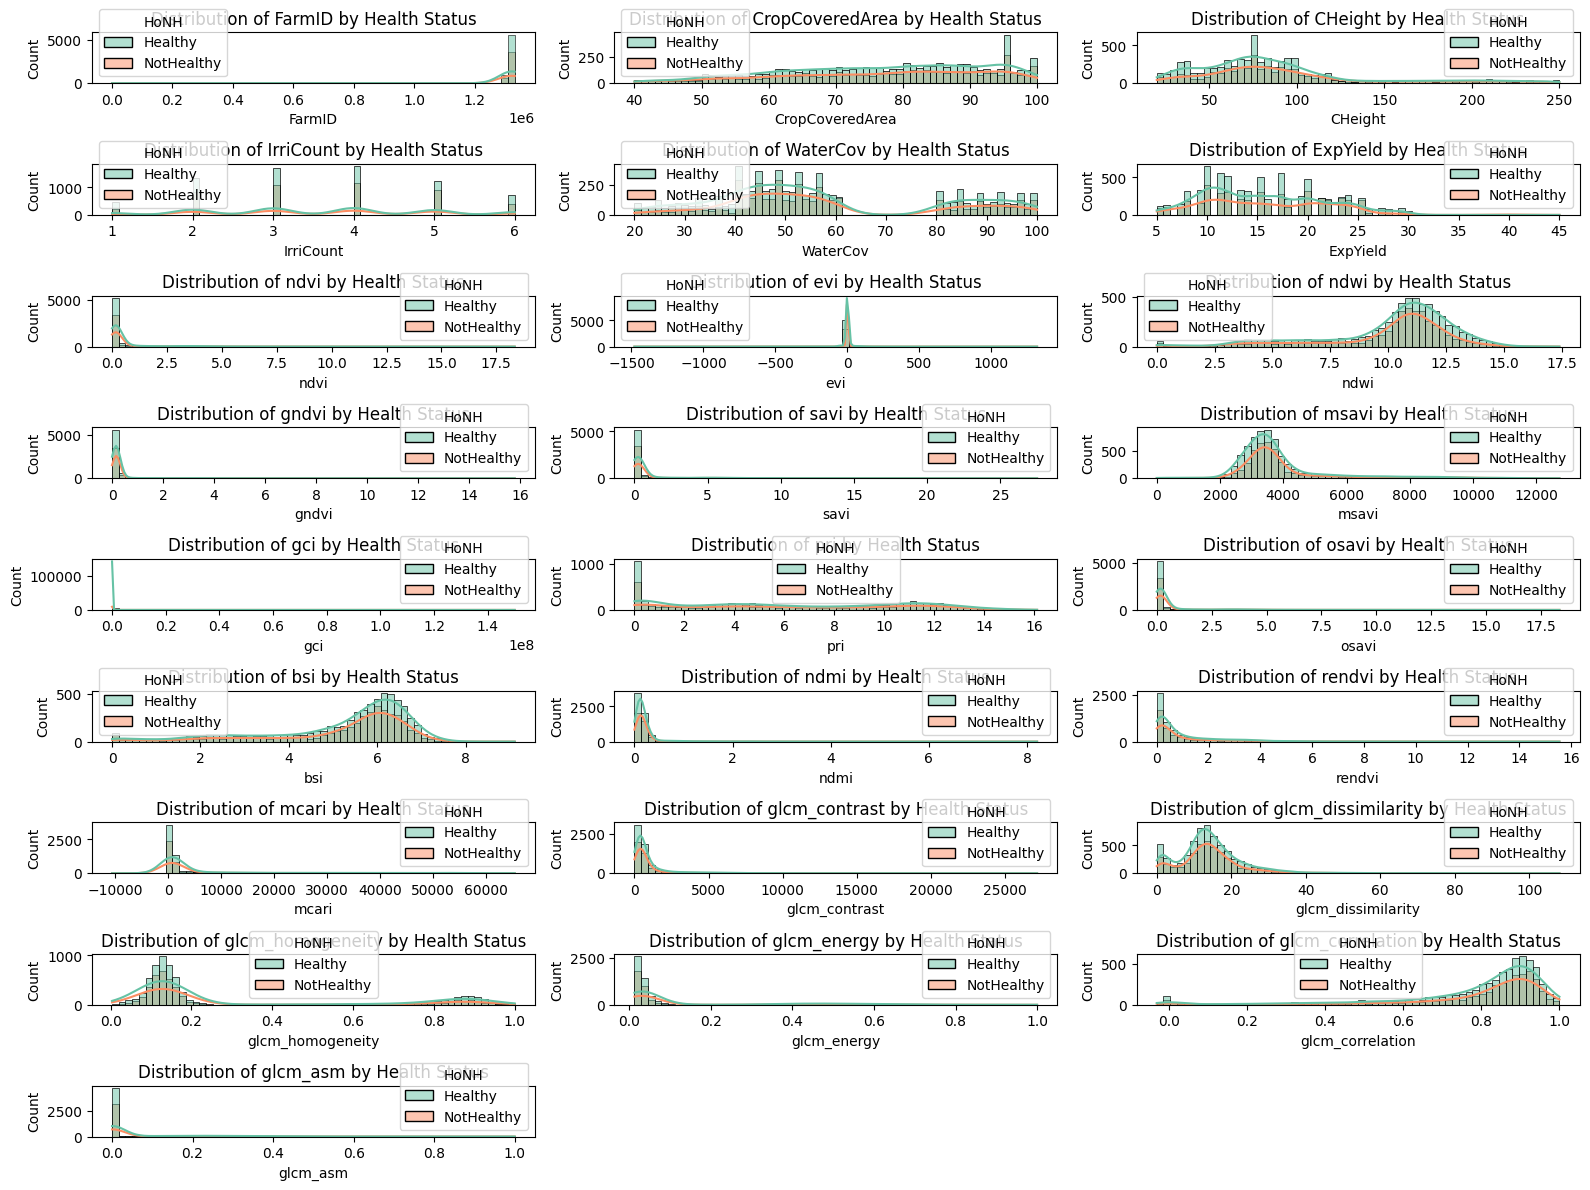

In [32]:
import seaborn as sns
import matplotlib.pyplot as plt

# Get numerical columns
numerical_data = data[data.FarmID.isin(train.FarmID.values)].select_dtypes('number')

# Plot the distribution for each numerical column, grouped by 'HoNH'
plt.figure(figsize=(16, 12))

for i, col in enumerate(numerical_data.columns, 1):
    plt.subplot(len(numerical_data.columns) // 3 + 1, 3, i)
    sns.histplot(data=data, x=col, hue='HoNH', kde=True, bins=60, palette="Set2")
    plt.title(f'Distribution of {col} by Health Status')
    plt.tight_layout()

plt.show()


- We see that data distribution isnt in the favour of our classification


### **Yea Johanson Transformation** on full data

- Making some oversampling 

In [ ]:
#pip install imblearn

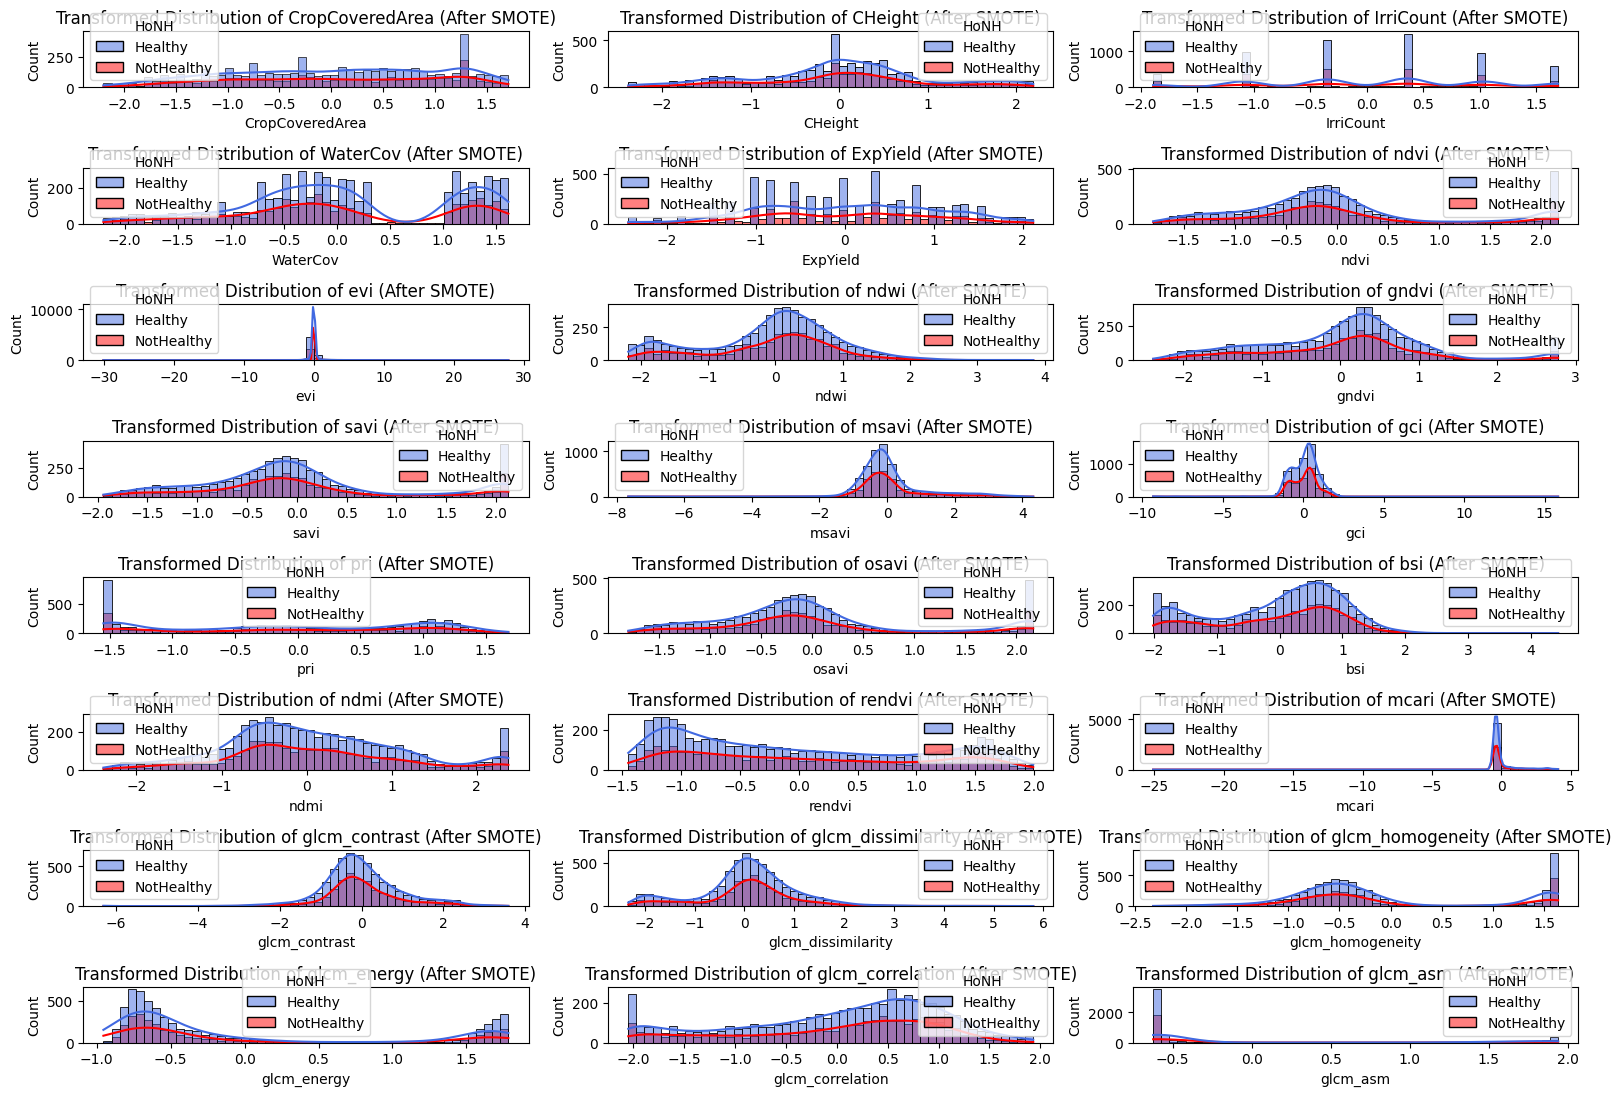

In [269]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import PowerTransformer
from imblearn.over_sampling import SMOTE

# Apply Yeo-Johnson transformation
pt = PowerTransformer(method='yeo-johnson')

# Select numerical features
numerical_data = data[data.FarmID.isin(train.FarmID.values)].select_dtypes('number')

# Handle infinities and NaNs before transformation
numerical_transformed = pt.fit_transform(numerical_data.replace([np.inf, -np.inf], np.nan))

# Convert back to DataFrame
transformed_df = pd.DataFrame(numerical_transformed, columns=numerical_data.columns)
transformed_df['HoNH'] = data[data.FarmID.isin(train.FarmID.values)].replace([np.inf, -np.inf], np.nan)['HoNH'].values  # Ensure labels are added back
transformed_df['FarmID'] = data[data.FarmID.isin(train.FarmID.values)].replace([np.inf, -np.inf], np.nan)['FarmID'].values  # Preserve FarmID

# Separate features and labels for SMOTE
X = transformed_df.drop(columns=['HoNH', 'FarmID']).dropna()
y = transformed_df.iloc[X.index]['HoNH']

from sklearn.preprocessing import LabelEncoder
from imblearn.over_sampling import SMOTE

# Encode categorical labels ("Healthy" -> 0, "NotHealthy" -> 1)
label_encoder = LabelEncoder()
y_numeric = label_encoder.fit_transform(y)  # Converts "Healthy" to 0 and "NotHealthy" to 1

# Apply SMOTE
smote = SMOTE(sampling_strategy=0.5, random_state=42)  # Make NotHealthy at least 50% of Healthy
X_resampled, y_resampled = smote.fit_resample(X, y_numeric)

# Convert back to DataFrame after SMOTE
resampled_df = pd.DataFrame(X_resampled, columns=X.columns)
resampled_df['HoNH'] = label_encoder.inverse_transform(y_resampled)  # Convert labels back to original names

# Now, you can continue with plotting!


# Plot transformed distributions after SMOTE
plt.figure(figsize=(16, 12))

for i, col in enumerate(resampled_df.columns[:-1], 1):  # Exclude HoNH for plotting
    plt.subplot(len(resampled_df.columns) // 3 + 1, 3, i)
    sns.histplot(data=resampled_df, x=col, hue='HoNH', kde=True, bins=50, palette=["royalblue", "red"])
    plt.title(f'Transformed Distribution of {col} (After SMOTE)')
    plt.tight_layout()

plt.show()



- Undersampling

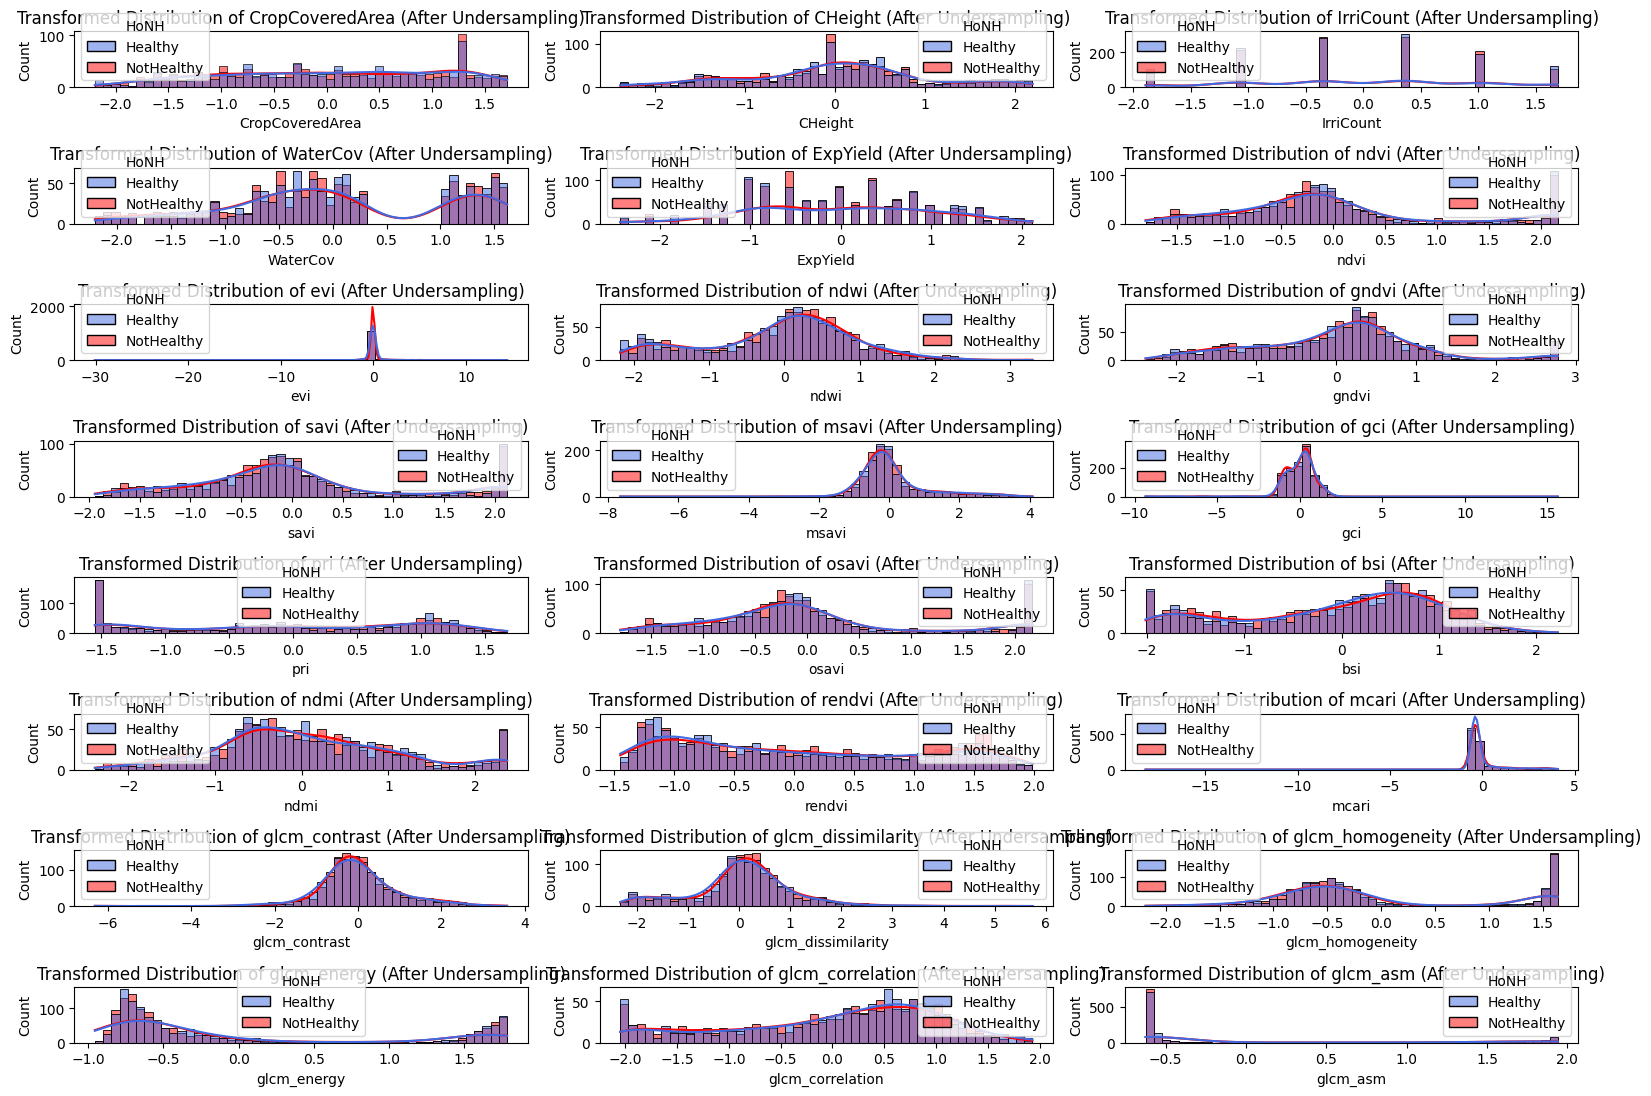

In [375]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import PowerTransformer
from imblearn.under_sampling import RandomUnderSampler

# Apply Yeo-Johnson transformation
pt = PowerTransformer(method='yeo-johnson')

# Select numerical features
full_numerical_data = data.drop(columns=['FarmID']).select_dtypes('number')#[data.FarmID.isin(train.FarmID.values)]
numerical_data = data[data.FarmID.isin(train.FarmID.values)].drop(columns=['FarmID']).select_dtypes('number')#

# Handle infinities and NaNs before transformation
full_numerical_transformed = pt.fit_transform(full_numerical_data.replace([np.inf, -np.inf], np.nan))
numerical_transformed = pt.fit_transform(numerical_data.replace([np.inf, -np.inf], np.nan))

# Convert back to DataFrame
transformed_df = pd.DataFrame(numerical_transformed, columns=numerical_data.columns)
full_transformed_df = pd.DataFrame(full_numerical_transformed, columns=numerical_data.columns)

transformed_df['HoNH'] = data[data.FarmID.isin(train.FarmID.values)].replace([np.inf, -np.inf], np.nan)['HoNH'].values  # Ensure labels are added back
transformed_df['FarmID'] = data[data.FarmID.isin(train.FarmID.values)].replace([np.inf, -np.inf], np.nan)['FarmID'].values  # Preserve FarmID

# Separate features and labels for undersampling
X = transformed_df.drop(columns=['HoNH', 'FarmID']).dropna()
y = transformed_df.iloc[X.index]['HoNH']

from sklearn.preprocessing import LabelEncoder

# Encode categorical labels ("Healthy" -> 0, "NotHealthy" -> 1)
label_encoder = LabelEncoder()
y_numeric = label_encoder.fit_transform(y)  # Converts "Healthy" to 0 and "NotHealthy" to 1

# Apply RandomUnderSampler to balance the classes by undersampling the majority class
undersampler = RandomUnderSampler(sampling_strategy=1.0, random_state=42)  # Keep an equal number of both classes
X_resampled, y_resampled = undersampler.fit_resample(X, y_numeric)

# Convert back to DataFrame after undersampling
resampled_df = pd.DataFrame(X_resampled, columns=X.columns)
resampled_df['HoNH'] = label_encoder.inverse_transform(y_resampled)  # Convert labels back to original names

# Now, you can continue with plotting!

# Plot transformed distributions after Undersampling
plt.figure(figsize=(16, 12))

for i, col in enumerate(resampled_df.columns[:-1], 1):  # Exclude HoNH for plotting
    plt.subplot(len(resampled_df.columns) // 3 + 1, 3, i)
    sns.histplot(data=resampled_df, x=col, hue='HoNH', kde=True, bins=50, palette=["royalblue", "red"])
    plt.title(f'Transformed Distribution of {col} (After Undersampling)')
    plt.tight_layout()

plt.show()


- Undersampling wouldn't be a great idea since we have very limited data (<10000)

In [376]:
full_transformed_df = pd.DataFrame(full_numerical_transformed, columns=full_numerical_data.columns)
full_transformed_df['FarmID']= data['FarmID']
full_transformed_df['HoNH']= data['HoNH']
full_transformed_df.shape,display (full_transformed_df.head())

,CropCoveredArea,CHeight,IrriCount,WaterCov,ExpYield,ndvi,evi,ndwi,gndvi,savi,...,rendvi,mcari,glcm_contrast,glcm_dissimilarity,glcm_homogeneity,glcm_energy,glcm_correlation,glcm_asm,FarmID,HoNH
0,1.453863,-0.700415,0.316617,1.277278,0.317210,-0.770343,-0.051059,-0.827352,-0.354753,-0.774267,...,0.186113,0.005368,0.467677,0.911231,-0.838959,-0.291924,-0.171114,-0.533932,1326576,Healthy
1,0.291947,-0.568561,1.019562,1.492662,-0.004509,-0.109533,-0.020161,0.452477,0.272283,-0.079168,...,-1.261851,-0.365723,0.039509,0.369076,-0.914623,-0.227956,-1.183828,-0.521895,1326577,Healthy
2,1.048848,0.272231,-0.409392,1.638090,0.759599,0.005177,-0.066175,-0.172647,0.434124,0.037980,...,-0.630416,-0.339536,0.776642,1.202057,-1.697935,-0.065362,-0.860140,-0.484939,1326578,Healthy
3,0.969958,-0.769873,1.019562,1.432593,0.159366,0.003100,0.017097,-0.049139,0.550185,0.035866,...,-1.014578,-0.351731,0.784497,1.202180,-0.786987,-0.314426,-0.657939,-0.537864,1331836,NotHealthy
4,1.208745,-0.666600,1.019562,1.580706,0.759599,-0.163976,-0.049918,-0.764939,0.012658,-0.135097,...,0.085992,-0.318352,0.932638,1.403546,-0.622513,0.110841,-1.198907,-0.432626,1326579,NotHealthy


((11791, 26), None)

**PCA**

- Good to inspect,but we will not use it

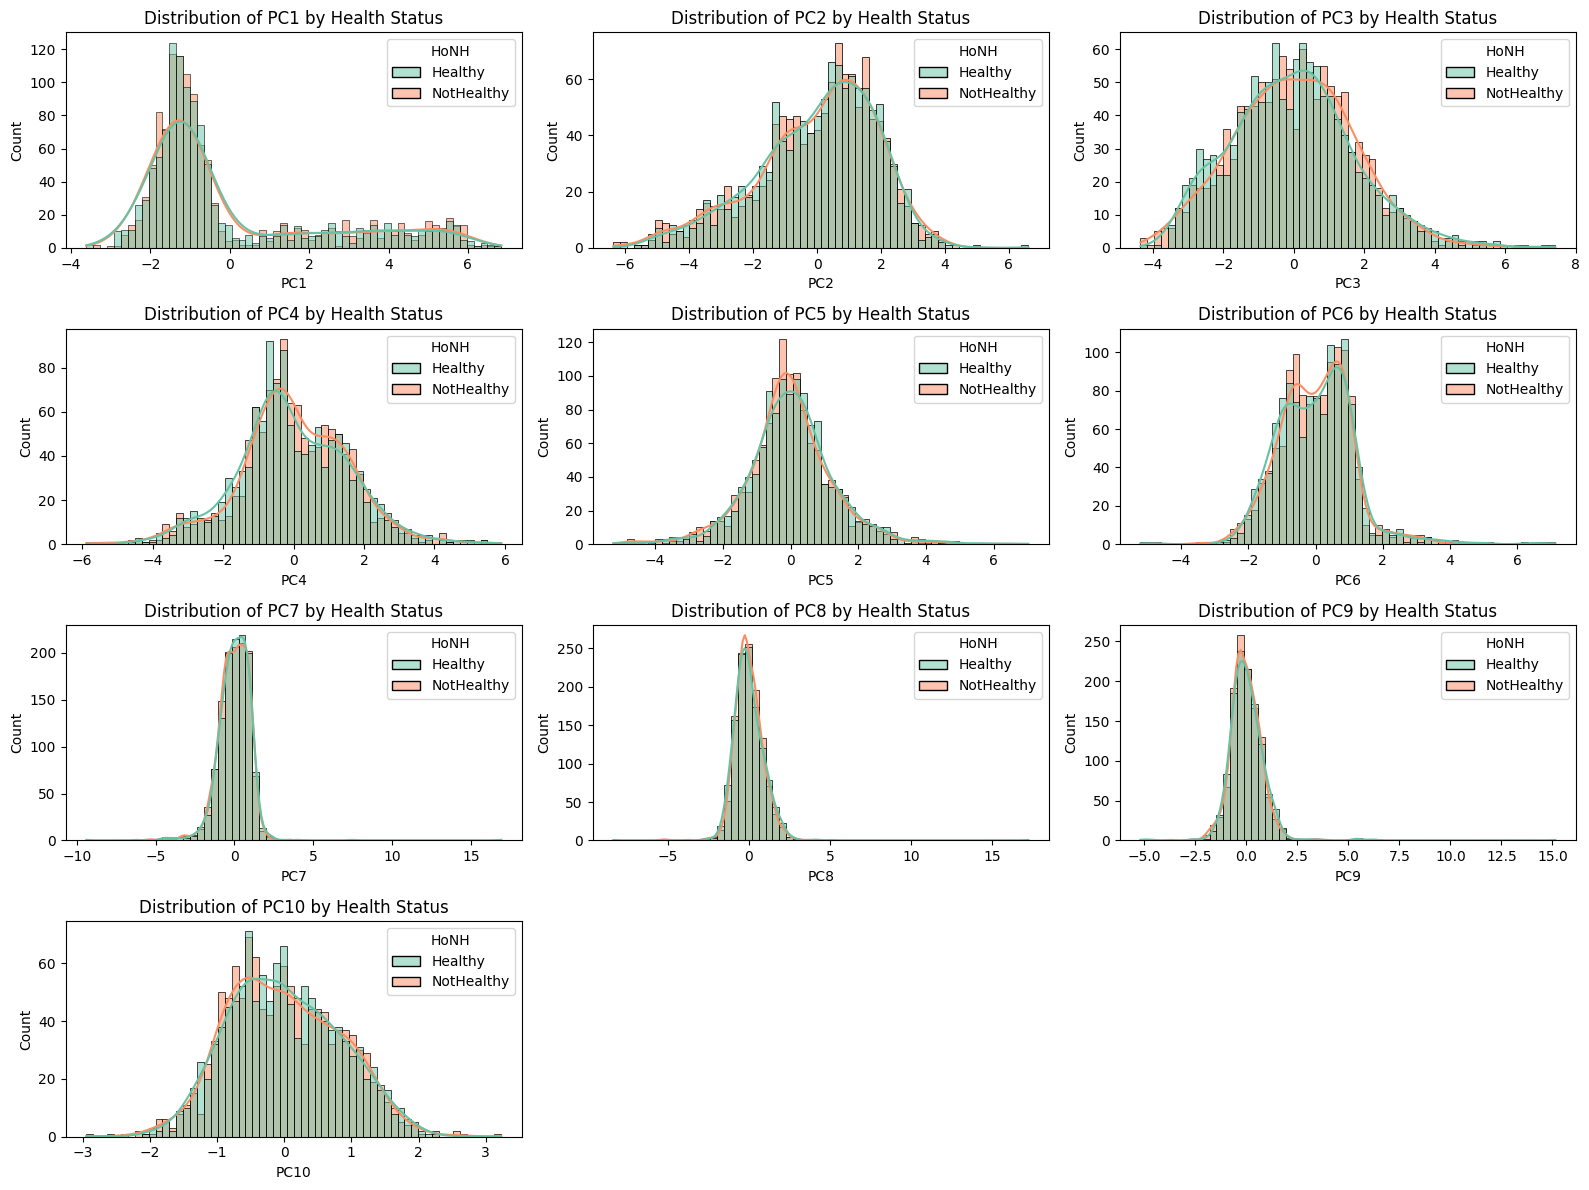

In [274]:
from sklearn.decomposition import PCA

# Apply PCA with 10 components
pca = PCA(n_components=10)
pca_components = pca.fit_transform(resampled_df.drop(columns=['HoNH']).fillna(0))

# Convert to DataFrame
pca_df = pd.DataFrame(pca_components, columns=[f'PC{i+1}' for i in range(10)])
pca_df['HoNH'] = resampled_df['HoNH'].values  # Add target class back

# Plot distributions of PCA components grouped by 'HoNH'
plt.figure(figsize=(16, 12))

for i, col in enumerate(pca_df.columns[:-1], 1):  # Exclude 'HoNH'
    plt.subplot(4, 3, i)  # Arrange in a grid layout
    sns.histplot(data=pca_df, x=col, hue='HoNH', kde=True, bins=60, palette="Set2")
    plt.title(f'Distribution of {col} by Health Status')
    plt.tight_layout()

plt.show()



In [277]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.decomposition import PCA
from sklearn.model_selection import cross_val_score, StratifiedKFold
from sklearn.linear_model import LogisticRegression
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import f1_score, classification_report, make_scorer

# Encode target labels
label_encoder = LabelEncoder()
y = label_encoder.fit_transform(resampled_df['HoNH'])

# PCA-transformed features
X = X_resampled  # Already computed from PCA

# Initialize Logistic Regression
log_reg = LogisticRegression(max_iter=10000)

# Cross-validation setup (Stratified K-Fold for class balance)
cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

# Use F1-score as the evaluation metric
f1_scorer = make_scorer(f1_score, average='weighted')

# Perform cross-validation
cv_scores = cross_val_score(log_reg, X, y, cv=cv, scoring=f1_scorer)

# Print Results
print(f"\nLogistic Regression with Cross-Validation Results:")
print(f"F1 Scores per Fold: {cv_scores}")
print(f"Mean F1 Score: {cv_scores.mean():.4f}")
print(f"Standard Deviation: {cv_scores.std():.4f}")



Logistic Regression with Cross-Validation Results:
F1 Scores per Fold: [0.51348088 0.51770326 0.51626004 0.49484089 0.50502834]
Mean F1 Score: 0.5095
Standard Deviation: 0.0085


- log1p for altering distrution?

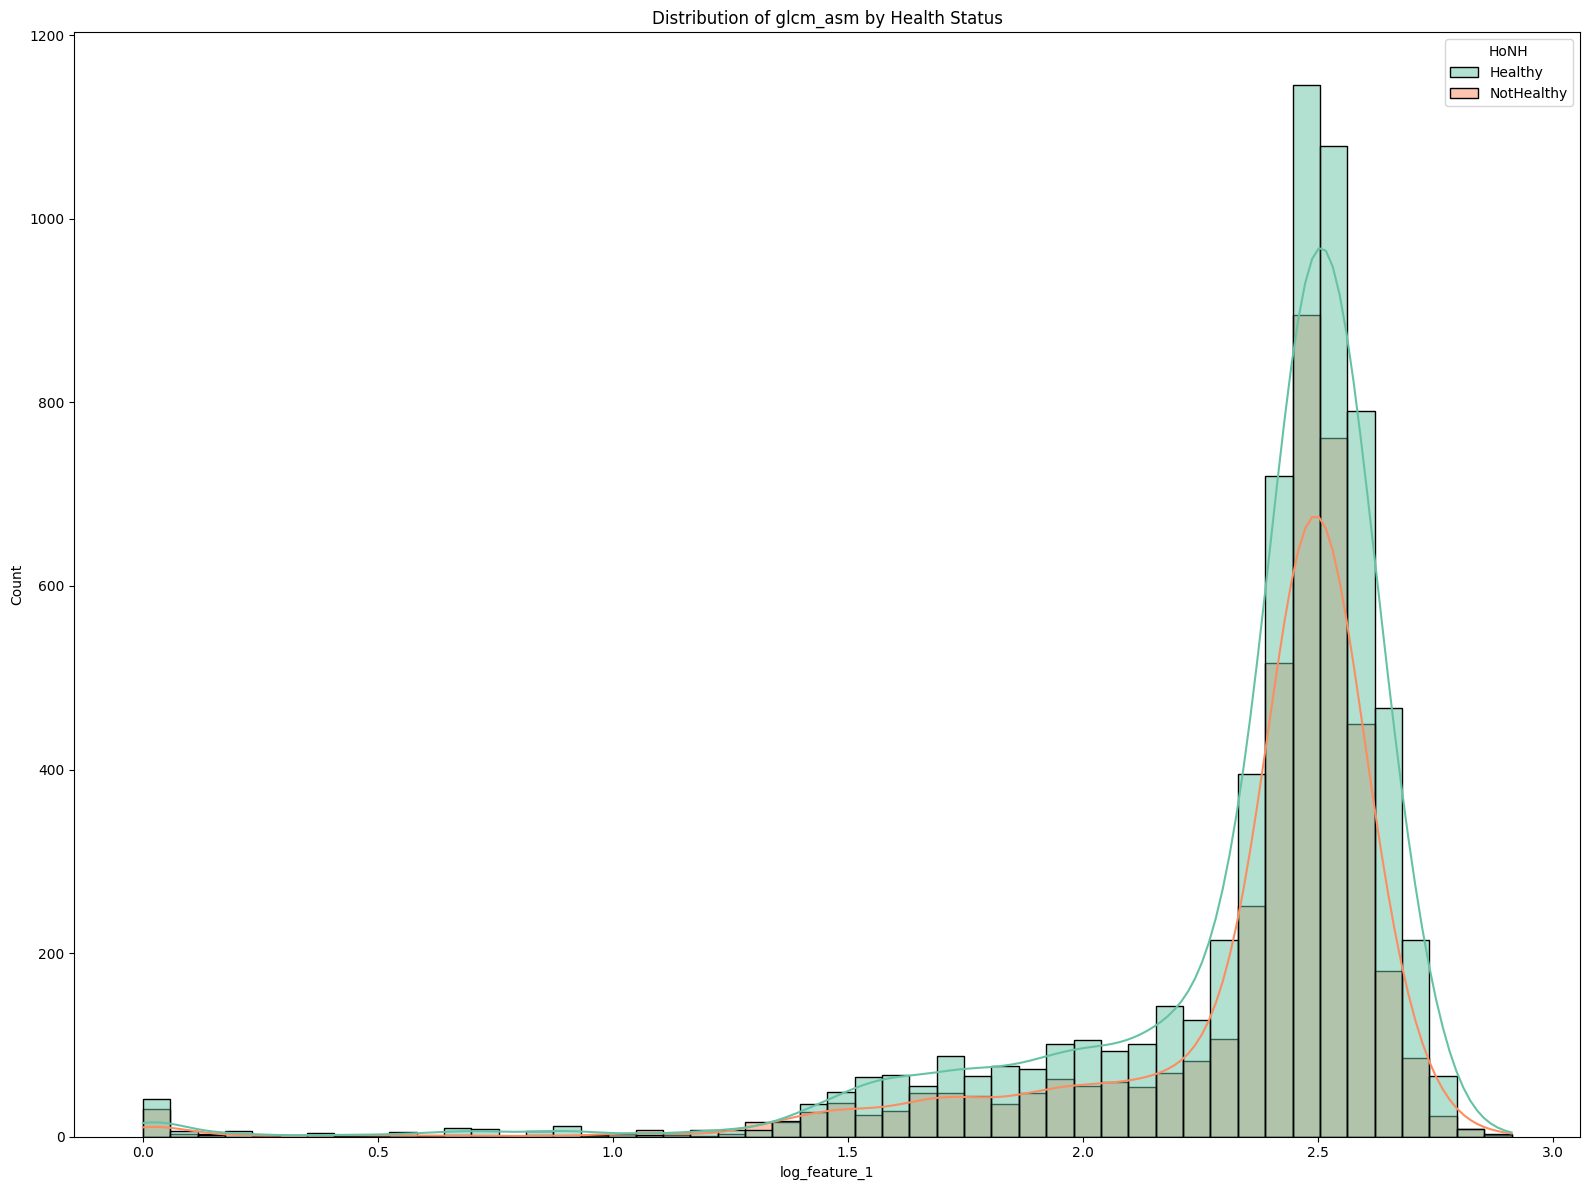

In [62]:
# Get numerical columns
numerical_data['HoNH'] =data.HoNH
numerical_data['feature1'] = numerical_data['ndwi'] * numerical_data['msavi']
numerical_data['log_feature_1'] = np.log1p(numerical_data['ndwi']) 

# Plot the distribution for each numerical column, grouped by 'HoNH'
plt.figure(figsize=(16, 12))

sns.histplot(data=numerical_data, x='log_feature_1', hue='HoNH', kde=True, bins=50, palette="Set2")
plt.title(f'Distribution of {col} by Health Status')
plt.tight_layout()

plt.show()

# Modeling

## **Num only predictions**
### Binary Classifier
- Predicts Healthy vs NonHealthy Crops

In [ ]:
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import StratifiedKFold, cross_val_score
from sklearn.metrics import f1_score, make_scorer
from sklearn.impute import SimpleImputer
import numpy as np
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier, VotingClassifier
from sklearn.svm import SVC

# Remove rows with missing target values
inference_data = full_transformed_df[full_transformed_df.FarmID.isin(train.FarmID.values)].dropna(subset=['HoNH']) # data in which we applied yao on train+test features

# inference_data = data[data.FarmID.isin(train.FarmID.values)].drop(columns=['FarmID']).select_dtypes('number')
# scaler_bin = PowerTransformer(method='yeo-johnson')
# numerical_transformed = scaler_bin.fit_transform(inference_data.replace([np.inf, -np.inf], np.nan))
# transformed_df = pd.DataFrame(numerical_transformed, columns=inference_data.columns)
# transformed_df['HoNH'] = data[data.FarmID.isin(train.FarmID.values)]['HoNH'].values  # Ensure labels are added back

# Select only numerical features
numerical_cols = full_transformed_df[full_transformed_df.FarmID.isin(train.FarmID.values)].dropna(subset=['HoNH'])
X = inference_data.drop(columns=['HoNH','evi'], errors='ignore').copy()
#inference_data[numerical_cols].drop(columns=['category', 'HoNH'], errors='ignore')  # Drop target if in numerical cols

# Replace infinite values with NaN
X.replace([np.inf, -np.inf], np.nan, inplace=True)

# Impute missing values (replace NaNs with mean)
imputer = SimpleImputer(strategy='mean')
X = imputer.fit_transform(X)

# Convert target variable to binary
y = inference_data['HoNH'].apply(lambda x: 1 if x == 'NotHealthy' else 0)

# Initialize models
logreg = LogisticRegression(max_iter=1000, random_state=42)
rf = RandomForestClassifier(n_estimators=100, random_state=42)
gb = GradientBoostingClassifier(n_estimators=100, random_state=42)
svc = SVC(probability=True, random_state=42)

# Create an ensemble model using VotingClassifier
ensemble_model = VotingClassifier(estimators=[
    ('logreg', logreg),
    ('rf', rf),
    ('gb', gb),
    ('svc', svc)
], voting='soft')

# Cross-validation setup
skf = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

# Compute F1 score using cross-validation
f1_scorer = make_scorer(f1_score, average='weighted')
f1_scores = cross_val_score(ensemble_model, X, y, cv=skf, scoring=f1_scorer)

# Print results
print(f"\nF1 Scores per fold: {f1_scores}")
print(f"Mean F1 Score: {np.mean(f1_scores):.4f} ± {np.std(f1_scores):.4f}")





F1 Scores per fold: [0.74602345 0.74513665 0.74513665 0.74586822 0.74586822]
Mean F1 Score: 0.7456 ± 0.0004


**Best Score from code above**
- F1 Scores per fold: [0.74602345 0.74513665 0.74513665 0.74586822 0.74586822]
- Mean F1 Score: 0.7456 ± 0.0004

In [388]:
data.head()

,FarmID,category,Crop,State,District,Sub-District,SDate,HDate,CropCoveredArea,CHeight,...,ndmi,rendvi,mcari,glcm_contrast,glcm_dissimilarity,glcm_homogeneity,glcm_energy,glcm_correlation,glcm_asm,HoNH
0,1326576,Healthy,Paddy,Telangana,Medak,Kulcharam,25-11-2023,14-04-2024,97,54,...,0.125265,0.568464,3932.788772,845.870370,21.796296,0.099442,0.045962,0.816874,0.002112,Healthy
1,1326577,Healthy,Paddy,Telangana,Medak,Kulcharam,13-11-2023,26-04-2024,82,58,...,0.118236,0.039324,674.886154,543.465587,16.323887,0.093640,0.049750,0.649683,0.002475,Healthy
2,1326578,Healthy,Paddy,Telangana,Medak,Kulcharam,19-12-2023,28-04-2024,92,91,...,0.131406,0.209200,864.816970,1167.146667,25.026667,0.042967,0.060000,0.715890,0.003600,Healthy
3,1331836,Diseased,Paddy,Telangana,Medak,Kulcharam,11-02-2023,04-11-2024,91,52,...,0.171215,0.098668,775.224667,1176.775439,25.028070,0.103544,0.044659,0.749821,0.001994,NotHealthy
4,1326579,Diseased,Paddy,Telangana,Medak,Kulcharam,12-12-2023,19-05-2024,94,55,...,0.084270,0.510771,1024.782906,1374.384615,27.384615,0.117199,0.072275,0.646116,0.005224,NotHealthy


In [293]:
numerical_cols.head()

,CropCoveredArea,CHeight,IrriCount,WaterCov,ExpYield,ndvi,evi,ndwi,gndvi,savi,...,rendvi,mcari,glcm_contrast,glcm_dissimilarity,glcm_homogeneity,glcm_energy,glcm_correlation,glcm_asm,FarmID,HoNH
0,1.453863,-0.700415,0.316617,1.277278,0.317210,-0.770343,-0.051059,-0.827352,-0.354753,-0.774267,...,0.186113,0.005368,0.467677,0.911231,-0.838959,-0.291924,-0.171114,-0.533932,1326576,Healthy
1,0.291947,-0.568561,1.019562,1.492662,-0.004509,-0.109533,-0.020161,0.452477,0.272283,-0.079168,...,-1.261851,-0.365723,0.039509,0.369076,-0.914623,-0.227956,-1.183828,-0.521895,1326577,Healthy
2,1.048848,0.272231,-0.409392,1.638090,0.759599,0.005177,-0.066175,-0.172647,0.434124,0.037980,...,-0.630416,-0.339536,0.776642,1.202057,-1.697935,-0.065362,-0.860140,-0.484939,1326578,Healthy
3,0.969958,-0.769873,1.019562,1.432593,0.159366,0.003100,0.017097,-0.049139,0.550185,0.035866,...,-1.014578,-0.351731,0.784497,1.202180,-0.786987,-0.314426,-0.657939,-0.537864,1331836,NotHealthy
4,1.208745,-0.666600,1.019562,1.580706,0.759599,-0.163976,-0.049918,-0.764939,0.012658,-0.135097,...,0.085992,-0.318352,0.932638,1.403546,-0.622513,0.110841,-1.198907,-0.432626,1326579,NotHealthy


- Checking num features correlation

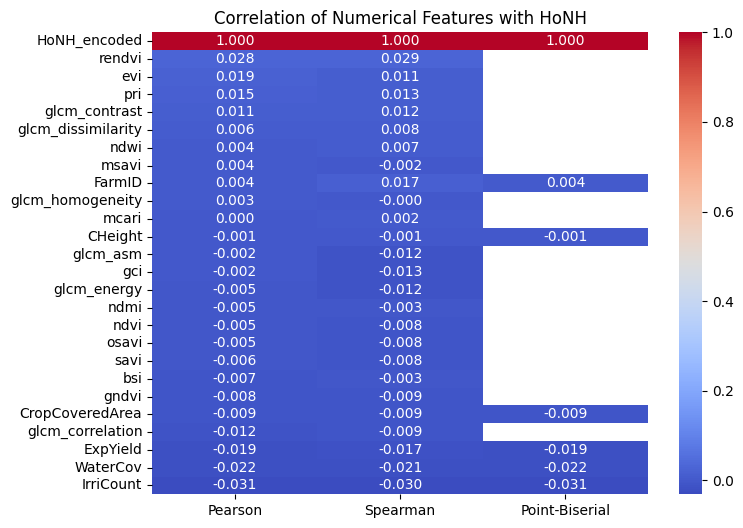


Top correlated features with HoNH:
                     Pearson  Spearman  Point-Biserial
HoNH_encoded        1.000000  1.000000        1.000000
rendvi              0.027692  0.029082             NaN
evi                 0.019353  0.010685             NaN
pri                 0.014693  0.013306             NaN
glcm_contrast       0.011422  0.012169             NaN
glcm_dissimilarity  0.005970  0.008369             NaN
ndwi                0.003822  0.006975             NaN
msavi               0.003675 -0.001945             NaN
FarmID              0.003549  0.017120        0.003549
glcm_homogeneity    0.003058 -0.000159             NaN


In [1006]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from scipy.stats import pointbiserialr
numerical_cols = full_transformed_df[full_transformed_df.FarmID.isin(train.FarmID.values)].dropna(subset=['HoNH'])

tem_df= numerical_cols.drop(columns=['HoNH']).copy()
# Encode target as binary (if not already)
tem_df['HoNH_encoded'] = numerical_cols['HoNH'].astype('category').cat.codes  

# Compute Pearson & Spearman correlation
pearson_corr = tem_df.corrwith(tem_df['HoNH_encoded'], method='pearson')
spearman_corr = tem_df.corrwith(tem_df['HoNH_encoded'], method='spearman')

# Compute Point-Biserial correlation for each numerical column
point_biserial_corr = {col: pointbiserialr(tem_df[col], tem_df['HoNH_encoded'])[0] for col in tem_df.columns}

# Combine into a DataFrame
correlation_df = pd.DataFrame({
    'Pearson': pearson_corr,
    'Spearman': spearman_corr,
    'Point-Biserial': point_biserial_corr
}).sort_values(by='Pearson', ascending=False)

# Plot heatmap
plt.figure(figsize=(8, 6))
sns.heatmap(correlation_df, annot=True, cmap="coolwarm", fmt=".3f")
plt.title("Correlation of Numerical Features with HoNH")
plt.show()

# Display top correlated features
print("\nTop correlated features with HoNH:")
print(correlation_df.head(10))

- Here we are going to add some statistcal based feature engineering

In [1245]:
import numpy as np
import pandas as pd
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import LabelEncoder
from imblearn.over_sampling import SMOTE
from sklearn.model_selection import train_test_split
from collections import Counter
from scipy.stats import skew, kurtosis

# Remove rows with missing target values
inference_data = full_transformed_df[full_transformed_df.FarmID.isin(train.FarmID.values)].dropna(subset=['HoNH'])

# Select only numerical features
numerical_cols = inference_data.select_dtypes(include=[np.number]).columns.tolist()

# Exclude target and other non-feature columns
X = inference_data.drop(columns=['HoNH', 'evi'], errors='ignore').copy()#, 'ExpYield'

# Replace infinite values with NaN
X.replace([np.inf, -np.inf], np.nan, inplace=True)

# Generate Statistical Features
X['mean'] = X.mean(axis=1)
X['std'] = X.std(axis=1)
X['min'] = X.min(axis=1)
X['max'] = X.max(axis=1)
X['skewness'] = X.apply(lambda row: skew(row, nan_policy='omit'), axis=1)
X['kurtosis'] = X.apply(lambda row: kurtosis(row, nan_policy='omit'), axis=1)
X['range'] = X['max'] - X['min']

# Interaction Features
X['sum'] = X.sum(axis=1)
X['median'] = X.median(axis=1)
X['iqr'] = X.quantile(0.75, axis=1) - X.quantile(0.25, axis=1)

# Rolling Window Features (if time-series data exists)
if 'timestamp' in inference_data.columns:
    rolling_features = inference_data.groupby('FarmID').rolling(window=3).agg(['mean', 'std', 'max', 'min']).reset_index(drop=True)
    rolling_features.columns = [f"{col[0]}_rolling_{col[1]}" for col in rolling_features.columns]
    X = pd.concat([X, rolling_features], axis=1)

# Impute missing values (replace NaNs with mean)
imputer = SimpleImputer(strategy='mean')
X = pd.DataFrame(imputer.fit_transform(X), columns=X.columns)

# Encode target labels ("Healthy" -> 0, "Not Healthy" -> 1)
label_encoder = LabelEncoder()
y = label_encoder.fit_transform(inference_data['HoNH'])

# Apply SMOTE to balance the classes
smote = SMOTE(sampling_strategy=0.9, random_state=42)  # Make Not Healthy at least 50% of Healthy
X_resampled, y_resampled = smote.fit_resample(X, y)

# Split the resampled data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X_resampled, y_resampled, test_size=0.2, shuffle=True, random_state=42)

# Print Data Shapes
print(f"Training Shape: {X_train.shape}, Testing Shape: {X_test.shape}")
print(f"Class Distribution (Train): {Counter(y_train)}, Class Distribution (Test): {Counter(y_test)}")


Training Shape: (9888, 34), Testing Shape: (2473, 34)
Class Distribution (Train): Counter({0: 5206, 1: 4682}), Class Distribution (Test): Counter({0: 1300, 1: 1173})


In [1246]:
from sklearn.metrics import classification_report
import joblib

# Create an ensemble model using VotingClassifier
ensemble_model = VotingClassifier(estimators=[
    ('logreg', logreg),
    ('rf', rf),
    ('gb', gb),
    # ('svc', svc)
], voting='soft')
ensemble_model.fit(X_train, y_train)
y_prob = ensemble_model.predict_proba(X_test)[:, 1]  # Get probability for class 1



In [ ]:

# Save the trained model
# joblib.dump(ensemble_model, 'models/HNH_classifier.pkl')

In [1247]:
from sklearn.metrics import f1_score

# Initialize variables to store the best threshold and the best F1 score
best_threshold = 0.35
best_f1_score = 0

# Iterate through thresholds from 0.35 to 0.6 with a step of 0.01
for threshold in np.arange(0.35, 0.61, 0.005):
    # Apply the current threshold
    y_pred = (y_prob > threshold).astype(int)
    
    # Calculate the F1 score
    current_f1_score = f1_score(y_test, y_pred, average='weighted')
    
    # Update the best threshold and F1 score if the current F1 score is better
    if current_f1_score > best_f1_score:
        best_f1_score = current_f1_score
        best_threshold = threshold

# Print the best threshold and the corresponding F1 score
print(f"Best Threshold: {best_threshold}")
print(f"Best F1 Score: {best_f1_score}")

# Apply the best threshold
y_pred = (y_prob > best_threshold).astype(int)

# Print probabilities and actual labels
print(f"Predicted Probabilities:\n{y_prob}")
print(f"Actual Labels:\n{y_test}")

print('f1_score:', f1_score(y_test, y_pred, average='weighted'))

# Evaluate performance
print("\nClassification Report:")
print(classification_report(y_pred, y_test))

Best Threshold: 0.43
Best F1 Score: 0.749729421719765
Predicted Probabilities:
[0.73358064 0.43688475 0.72916128 ... 0.31492617 0.41698351 0.41195338]
Actual Labels:
[1 0 1 ... 0 0 1]
f1_score: 0.8596816489715304

Classification Report:
              precision    recall  f1-score   support

           0       0.87      0.87      0.87      1301
           1       0.85      0.85      0.85      1172

    accuracy                           0.86      2473
   macro avg       0.86      0.86      0.86      2473
weighted avg       0.86      0.86      0.86      2473



- 0.7 oversampling
- 

Classification Report:
              precision    recall  f1-score   support

           0       0.94      0.83      0.88      1452
           1       0.73      0.89      0.81       760

    accuracy                           0.85      2212
-   macro avg       0.84      0.86      0.84      2212
- weighted avg       0.87      0.85      0.85      2212


**Top scoring:**
- `['CropCoveredArea', 'CHeight', 'IrriCount', 'WaterCov', 'ndvi', 'ndwi',
       'gndvi', 'savi', 'msavi', 'gci', 'pri', 'osavi', 'bsi', 'ndmi',
       'rendvi', 'mcari', 'glcm_contrast', 'glcm_dissimilarity',
       'glcm_homogeneity', 'glcm_energy', 'glcm_correlation', 'glcm_asm',
       'FarmID', 'mean', 'std', 'min', 'max', 'skewness', 'kurtosis', 'range',
       'sum', 'median', 'iqr']`
- SMOTE(sampling_strategy=0.5, random_state=42)
- `ensemble_model = VotingClassifier(estimators=[
    ('logreg', logreg),
    ('rf', rf),
    ('gb', gb),
], voting='soft')`


Classification Report:
              precision    recall  f1-score   support

           0       0.98      0.81      0.89      1588
           1       0.53      0.94      0.68       364

    accuracy                           0.83      1952
-   macro avg       0.76      0.88      0.78      1952
- weighted avg       0.90      0.83      0.85      1952`

In [392]:
inference_data.columns

Index(['CropCoveredArea', 'CHeight', 'IrriCount', 'WaterCov', 'ExpYield',
       'ndvi', 'evi', 'ndwi', 'gndvi', 'savi', 'msavi', 'gci', 'pri', 'osavi',
       'bsi', 'ndmi', 'rendvi', 'mcari', 'glcm_contrast', 'glcm_dissimilarity',
       'glcm_homogeneity', 'glcm_energy', 'glcm_correlation', 'glcm_asm',
       'FarmID', 'HoNH'],
      dtype='object')

In [513]:
# evaluate CV
ensemble_model_cv = VotingClassifier(estimators=[
    ('logreg', logreg),
    ('rf', rf),
    ('gb', gb),
    # ('svc', svc)
], voting='soft')
# Cross-validation setup
skf = StratifiedKFold(n_splits=7, shuffle=True, random_state=42)

# Compute F1 score using cross-validation
f1_scorer = make_scorer(f1_score, average='weighted')
f1_scores = cross_val_score(ensemble_model_cv, X_resampled, y_resampled, cv=skf, scoring=f1_scorer)

# Print results
print(f"\nF1 Scores per fold: {f1_scores}")
print(f"Mean F1 Score: {np.mean(f1_scores):.4f} ± {np.std(f1_scores):.4f}")




F1 Scores per fold: [0.83132818 0.82144836 0.84002558 0.83573003 0.83015247 0.83052334
 0.83611341]
Mean F1 Score: 0.8322 ± 0.0055


In [1052]:
## This code is commented, because the nh classifer below should be ran first to get the nh predictions

# y_binary_pred_cv = ensemble_model.predict_proba(X_test)[:, 1]
# # Apply custom threshold (0.4)
# y_binary_pred_cv = (y_binary_pred_cv > 0.45).astype(int)

# print(Counter(y_binary_pred_cv))
# # 3. Identify "Not Healthy" Samples for Multi-Class Classification
# not_healthy_indices = np.where(y_binary_pred_cv == 1)[0]


# X_NH_cv = data_train.iloc[test_idx].select_dtypes('number').reset_index(drop=True).iloc[not_healthy_indices].drop(columns=['FarmID','evi']).fillna(0).drop(columns=['HoNH', 'evi'], errors='ignore')
# display(X_NH_cv.head())
# X_NH_cv = scaler.transform(X_NH_cv)

# y_multi = data[data.FarmID.isin(train.FarmID.values)]['category'].iloc[test_idx]  # Only use samples classified as "Not Healthy"
# print(f"Number of 'Not Healthy' Samples: {len(y_NH_cv)}")
# # Initialize with 'Healthy'
# y_multi_pred_cv = pd.Series(['Healthy'] * len(y_multi), index=y_multi.index)

# # Predict categories for "Not Healthy" samples
# y_multi_pred_cv.iloc[not_healthy_indices] = le_nh.inverse_transform(logreg_nh.predict(X_NH_cv))

# # Print the counts of each category
# print(y_multi_pred_cv.value_counts())

# print(classification_report(y_multi_pred_cv, y_multi))
# print('f1_score:',f1_score(y_multi_pred_cv, y_multi, average
#                            ='weighted'))

Counter({0: 1544, 1: 668})


IndexError: positional indexers are out-of-bounds

In [770]:
data[data.FarmID.isin(train.FarmID.values)]['category'].value_counts()

category
Healthy     6506
Pests        485
Diseased     474
Stressed     423
Name: count, dtype: int64

### NH classifier
- Predicts the type of non-healthy crops

In [1187]:
## applying FE
import numpy as np
import pandas as pd
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split
from scipy.stats import skew, kurtosis
from collections import Counter

# Filter NotHealthy Data
inference_data_NH = full_transformed_df[
    full_transformed_df.FarmID.isin(train.FarmID.values) & (full_transformed_df.HoNH == 'NotHealthy')
].dropna(subset=['HoNH'])

# Encode the target variable (categorical classification)
le_nh = LabelEncoder()
y = data[data.FarmID.isin(train.FarmID.values) & (data.HoNH == 'NotHealthy')]['category']
print("Category Distribution (Before Encoding):", Counter(y))
y = le_nh.fit_transform(y)

# # Drop non-feature columns
# X_NH = inference_data_NH.drop(columns=['HoNH', 'evi' ], errors='ignore').copy()
data_train = data[data.FarmID.isin(train.FarmID.values)]
numerical_data = data_train[data_train.HoNH!='Healthy'].select_dtypes('number')
numerical_data['category'] =data_train[data_train.HoNH!='Healthy']['category']

# Prepare the data
X_NH = numerical_data.drop(columns=['category', 'evi']).fillna(0)#.replace([np.inf, -np.inf], np.nan)

# Apply Yeo-Johnson Transformation
scaler = PowerTransformer(method='yeo-johnson')
X_scaled = scaler.fit_transform(X_NH.drop(columns=['FarmID']))
X_scaled = pd.DataFrame(X_scaled, columns=X_NH.drop(columns=['FarmID']).columns)


# X_concat = pd.concat([X_scaled.reset_index(drop=True), categorical_data[categorical_data.dataset=='train'][categorical_data.HoNH!='Healthy'][cat_cols_numed].reset_index(drop=True)], axis=1).dropna()
# # Encode target labels ("Healthy" -> 0, "Not Healthy" -> 1)


# Train-Test Split
X_train, X_test, y_train, y_test = train_test_split(X_scaled, y, test_size=0.2, shuffle=True, random_state=42)


# Print Data Shapes
print(f"Training Shape: {X_train.shape}, Testing Shape: {X_test.shape}")
print(f"Category Distribution (Train): {Counter(y_train)}, Category Distribution (Test): {Counter(y_test)}")


Category Distribution (Before Encoding): Counter({'Pests': 485, 'Diseased': 474, 'Stressed': 423})
Training Shape: (1105, 27), Testing Shape: (277, 27)
Category Distribution (Train): Counter({1: 389, 0: 381, 2: 335}), Category Distribution (Test): Counter({1: 96, 0: 93, 2: 88})


In [1188]:
data_test = data[data.FarmID.isin(test.FarmID.values)]
Xprednh = scaler.transform(data_test.select_dtypes('number').drop(columns=['FarmID','evi']).fillna(0))
Xprednh


array([[ 0.20930068,  0.5058698 ,  1.08972295, ..., -0.50628847,
        -0.48370318, -0.58585402],
       [ 0.95924831, -0.31973988,  1.08972295, ..., -0.77259863,
         0.58121013, -0.61161561],
       [ 1.19561751,  0.31183893,  1.08972295, ..., -0.40909028,
         0.07392282, -0.57207523],
       ...,
       [ 0.65220507,  1.86552189, -0.2755838 , ..., -0.72899636,
         1.1839299 , -0.60845499],
       [ 1.27555612,  1.81349092,  0.42399426, ..., -0.63172958,
         0.67243894, -0.59998713],
       [-0.00407538,  1.63777142, -1.02010597, ..., -0.75875237,
         0.47957584, -0.61065246]])

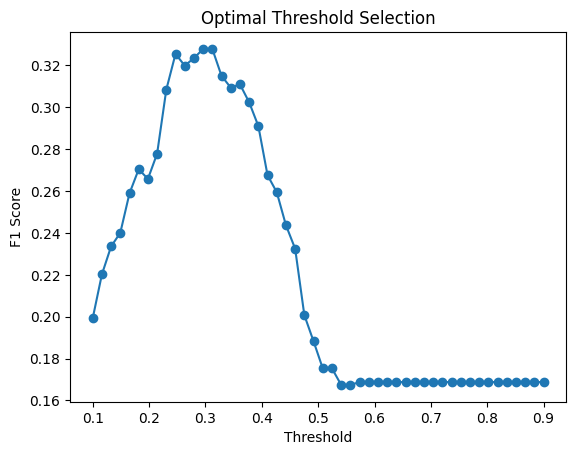


Best Threshold: 0.31 (F1-score: 0.3279)

Final Classification Report:
              precision    recall  f1-score   support

           0       0.39      0.62      0.48        93
           1       0.42      0.56      0.48        96
           2       0.00      0.00      0.00        88

    accuracy                           0.40       277
   macro avg       0.27      0.40      0.32       277
weighted avg       0.28      0.40      0.33       277



In [1206]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import f1_score, precision_recall_curve, classification_report
# Create an ensemble model using VotingClassifier
ensemble_model = VotingClassifier(estimators=[
    ('logreg', logreg),
    ('rf', rf),
    ('gb', gb),
    # ('svc', svc)
], voting='soft')
ensemble_model.fit(X_train, y_train)

# Predict probabilities
y_prob = ensemble_model.predict_proba(X_test)[:, 1]

# Try different thresholds and compute F1-score
thresholds = np.linspace(0.1, 0.9, 50)  # Try 50 different thresholds
best_threshold = 0.5  # Default
best_f1 = 0

f1_scores = []
for threshold in thresholds:
    y_pred = (y_prob > threshold).astype(int)
    f1 = f1_score(y_test, y_pred, average='weighted')
    f1_scores.append(f1)

    if f1 > best_f1:
        best_f1 = f1
        best_threshold = threshold

# Plot F1-score vs. Threshold
plt.plot(thresholds, f1_scores, marker='o')
plt.xlabel("Threshold")
plt.ylabel("F1 Score")
plt.title("Optimal Threshold Selection")
plt.show()

# Apply the best threshold
y_pred_final = (y_prob > best_threshold).astype(int)

# Print the best threshold
print(f"\nBest Threshold: {best_threshold:.2f} (F1-score: {best_f1:.4f})")
print("\nFinal Classification Report:")
print(classification_report(y_test, y_pred_final))


- class 2 is underrepresented 


Save the trained model
joblib.dump(logreg_nh, 'models/NH_classifier.pkl')

In [486]:


logreg_nh_cv = LogisticRegression(max_iter=10000)

# Cross-validation setup
skf = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

# Compute F1 score using cross-validation
f1_scorer = make_scorer(f1_score, average='weighted')
f1_scores = cross_val_score(logreg_nh_cv, X_scaled, y, cv=skf, scoring=f1_scorer)

# Print results
print(f"\nF1 Scores per fold: {f1_scores}")
print(f"Mean F1 Score: {np.mean(f1_scores):.4f} ± {np.std(f1_scores):.4f}")


F1 Scores per fold: [0.43572854 0.37313886 0.38415479 0.39220153 0.38104886]
Mean F1 Score: 0.3933 ± 0.0221


**Top Scoring NH_Classifier**
- 
precision    recall  f1-score   support

           0       0.47      0.35      0.40       110
           1       0.51      0.40      0.45       126
           2       0.20      0.46      0.28        41

    accuracy                           0.39       277
-   macro avg       0.39      0.40      0.38       277
- weighted avg       0.45      0.39      0.40       277

#### Test Prediction

In [948]:
test.head()

,FarmID,Crop,State,District,Sub-District,SDate,HDate,CropCoveredArea,CHeight,CNext,CLast,CTransp,IrriType,IrriSource,IrriCount,WaterCov,ExpYield,Season,geometry
0,85197,Paddy,Telangana,Medak,Nizampet,2023-11-12 0:00:00,2024-05-14 0:00:00,81,99,Lentil,Pea,Transplanting,Flood,Groundwater,5,81,19,Rabi,"POLYGON ((78.54742 18.06231, 78.54762 18.06226..."
1,779677,Paddy,Telangana,Medak,Nizampet,2023-12-20 0:00:00,2024-05-28 0:00:00,91,63,Lentil,Pea,Transplanting,Flood,Canal,5,97,15,Rabi,"POLYGON ((78.54813 18.06739, 78.54855 18.06816..."
2,1331840,Paddy,Telangana,Medak,Nizampet,2023-11-29 0:00:00,2024-05-18 0:00:00,94,89,Pea,Lentil,Transplanting,Flood,Canal,5,88,15,Rabi,"POLYGON ((78.56003 18.07961, 78.56037 18.07955..."
3,483053,Paddy,Telangana,Medak,Nizampet,2023-01-11 0:00:00,2024-04-27 0:00:00,83,78,Pea,Lentil,Transplanting,Flood,Canal,5,98,17,Rabi,"POLYGON ((78.56217 18.08121, 78.56241 18.08121..."
4,542945,Paddy,Telangana,Medak,Nizampet,2023-04-11 0:00:00,2024-04-25 0:00:00,82,53,Lentil,Pea,Transplanting,Flood,Canal,6,98,18,Rabi,"POLYGON ((78.56845 18.08473, 78.56875 18.08474..."


In [313]:
full_transformed_df[full_transformed_df.FarmID.isin(test.FarmID.values)]

,CropCoveredArea,CHeight,IrriCount,WaterCov,ExpYield,ndvi,evi,ndwi,gndvi,savi,...,rendvi,mcari,glcm_contrast,glcm_dissimilarity,glcm_homogeneity,glcm_energy,glcm_correlation,glcm_asm,FarmID,HoNH
8775,0.220193,0.431284,1.019562,1.080272,0.616891,-0.269156,-0.056772,-0.560243,0.043775,-0.243865,...,-1.277818,-0.353620,-0.095763,0.287070,-0.766188,-0.472865,-0.586648,-0.561510,85197,NaN
8776,0.969958,-0.415437,1.019562,1.580706,-0.004509,-1.474551,-0.057382,-1.376474,-1.414341,-1.554137,...,1.379006,-0.439347,-0.057142,0.497770,-1.050870,-0.765864,0.528756,-0.589743,779677,NaN
8777,1.208745,0.230371,1.019562,1.308954,-0.004509,-0.914355,-0.171099,-0.277158,-0.599595,-0.930445,...,1.468745,-0.337499,0.233089,0.795282,-1.242351,-0.366681,-0.007600,-0.546420,1331840,NaN
8778,0.364421,-0.017345,1.019562,1.609526,0.317210,0.002722,-0.006083,-0.039741,0.509897,0.035482,...,-1.223588,-0.358779,0.582000,0.990707,-0.620091,0.039007,-0.227779,-0.455677,483053,NaN
8779,0.291947,-0.734832,1.703890,1.609526,0.469563,0.034836,-0.042111,-0.184773,0.531523,0.068099,...,-1.222417,-0.349797,1.050275,1.389414,-0.646338,-0.065258,-0.517426,-0.484913,542945,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
11786,1.048848,2.007613,0.316617,-0.529382,2.901897,0.187219,0.050484,-1.626465,-1.685205,0.221818,...,1.241731,1.831876,1.043828,-0.704839,1.662789,1.822458,-1.556224,1.985940,551119,NaN
11787,0.078852,2.100678,-0.409392,-0.707283,2.994385,-0.010904,0.153226,0.194945,0.648324,0.021616,...,-1.136485,-0.384341,0.878579,1.219091,-0.658899,-0.487372,-1.062135,-0.563349,916476,NaN
11788,0.661487,1.873359,-0.409392,-0.587487,3.085447,-0.222048,-0.015424,0.925942,0.357243,-0.195065,...,0.464545,-0.397384,-0.360496,-0.081356,-0.221679,-0.717693,1.175519,-0.586278,121860,NaN
11789,1.289749,1.817047,0.316617,-0.307799,2.901897,0.232243,-0.034290,0.010657,0.841225,0.266834,...,-1.133482,-0.347853,-0.330799,-0.092132,-0.212188,-0.610511,0.626034,-0.576996,270936,NaN


In [1248]:
test_data = full_transformed_df[full_transformed_df.FarmID.isin(test.FarmID.values)]
# # Select only numerical features
# numerical_cols = full_transformed_df[full_transformed_df.FarmID.isin(test.FarmID.values)].dropna(subset=['HoNH'])
# Xpred = test_data.drop(columns=['HoNH', 'evi'], errors='ignore').copy()
# #inference_data[numerical_cols].drop(columns=['category', 'HoNH'], errors='ignore')  # Drop target if in numerical cols

# # Replace infinite values with NaN
# Xpred.replace([np.inf, -np.inf], np.nan, inplace=True)
# print(Xpred.shape)
# # Impute missing values (replace NaNs with mean)
# Xpred = imputer.transform(Xpred)


# Exclude target and other non-feature columns
Xpred = test_data.drop(columns=['HoNH', 'evi',], errors='ignore').copy()#'ExpYield'
X = Xpred.copy()
# Replace infinite values with NaN
X.replace([np.inf, -np.inf], np.nan, inplace=True)

# Generate Statistical Features
X['mean'] = X.mean(axis=1)
X['std'] = X.std(axis=1)
X['min'] = X.min(axis=1)
X['max'] = X.max(axis=1)
X['skewness'] = X.apply(lambda row: skew(row, nan_policy='omit'), axis=1)
X['kurtosis'] = X.apply(lambda row: kurtosis(row, nan_policy='omit'), axis=1)
X['range'] = X['max'] - X['min']

# Interaction Features
X['sum'] = X.sum(axis=1)
X['median'] = X.median(axis=1)
X['iqr'] = X.quantile(0.75, axis=1) - X.quantile(0.25, axis=1)

# Rolling Window Features (if time-series data exists)
if 'timestamp' in inference_data.columns:
    rolling_features = inference_data.groupby('FarmID').rolling(window=3).agg(['mean', 'std', 'max', 'min']).reset_index(drop=True)
    rolling_features.columns = [f"{col[0]}_rolling_{col[1]}" for col in rolling_features.columns]
    X = pd.concat([X, rolling_features], axis=1)

In [1212]:
# Load the model
# ensemble_model = joblib.load('models/HNH_classifier.pkl')

In [1273]:
# Predict probabilities
y_prob = ensemble_model.predict_proba(X.fillna(0))[:, 1]  # Get probability for class 1

# Apply custom threshold (0.4)
y_pred = (y_prob > 0.5).astype(int)# top 0.4
Counter(y_pred)

Counter({0: 2687, 1: 31})

- mapping non healthy, so we can pass them to nh_classifier

In [1275]:

# Create a results DataFrame
results_df = pd.DataFrame()
results_df['ID'] = test_data['FarmID']
results_df['Target'] = np.where(y_pred == 1, "NotHealthy", "Healthy")
display(results_df.head())

# Separate 'Not Healthy' samples for further classification
not_healthy_samples = results_df[results_df['Target'] == "NotHealthy"]

,ID,Target
8775,85197,Healthy
8776,779677,Healthy
8777,1331840,Healthy
8778,483053,Healthy
8779,542945,Healthy


In [1276]:
not_healthy_samples

,ID,Target
8853,1326806,NotHealthy
8960,1327558,NotHealthy
9158,1328598,NotHealthy
9201,1328717,NotHealthy
9220,1328749,NotHealthy
9249,1328784,NotHealthy
9311,1329334,NotHealthy
9312,1329335,NotHealthy
9379,1329751,NotHealthy
9384,1329756,NotHealthy


In [1277]:
data_test = data[data.FarmID.isin(test.FarmID.values)]

# Extract features of Not Healthy samples for nh_classifier
nh_Xpred = data_test.select_dtypes('number').drop(columns=['FarmID','evi']).fillna(0).loc[not_healthy_samples.index].drop(columns=['HoNH', 'evi'], errors='ignore')

# Apply preprocessing steps
# nh_Xpred.replace([np.inf, -np.inf], np.nan, inplace=True)
nh_Xpred = scaler.transform(nh_Xpred)

In [1278]:
nh_Xpred.shape

(31, 23)

In [1283]:
# Load the model
logreg_nh = joblib.load('models/NH_classifier.pkl')

In [1282]:


# Predict the specific disease/type
#  using nh_classifier
nh_predictions = logreg_nh.predict(nh_Xpred)

# Map predictions back to the DataFrame
results_df.loc[not_healthy_samples.index, 'Target'] = le_nh.inverse_transform(nh_predictions)

# Fill 'Target' as 'Healthy' for samples predicted as Healthy
results_df['Target'] = results_df['Target'].fillna("Healthy")

# Load sample submission file
sample_submission = pd.read_csv(root_path / "SampleSubmission.csv")

# Merge with sample submission format
final_submission = sample_submission[['ID']].merge(results_df, on='ID', how='left')

# Save submission file
final_submission.to_csv(root_path / "FinalSubmission.csv", index=False)

# Display final submission preview
final_submission.head()

,ID,Target
0,85197,Healthy
1,779677,Healthy
2,1331840,Healthy
3,483053,Healthy
4,542945,Healthy


In [ ]:
len(nh_predictions), nh_predictions, Counter(nh_predictions), nh_Xpred.shape

(83,
 array([1, 0, 0, 1, 1, 1, 0, 1, 0, 0, 0, 0, 1, 1, 1, 1, 1, 0, 0, 0, 0, 1,
        0, 0, 1, 1, 1, 1, 1, 0, 1, 1, 2, 2, 2, 1, 1, 1, 1, 1, 1, 1, 1, 1,
        1, 0, 1, 0, 1, 0, 0, 1, 1, 0, 0, 0, 1, 1, 0, 0, 1, 1, 1, 0, 1, 0,
        0, 0, 1, 1, 0, 1, 1, 0, 1, 0, 0, 1, 0, 1, 0, 1, 0]),
 Counter({1: 46, 0: 34, 2: 3}),
 (31, 23))

# Analysis of Categorical features and their impact

In [1115]:
categorical_data = data.select_dtypes('object').copy()
categorical_data.drop(columns=['tif_path', 'full_tif_path', 'State', 'geometry'], inplace=True)
categorical_data.head()

,category,Crop,State,District,Sub-District,SDate,HDate,CNext,CLast,CTransp,IrriType,IrriSource,Season,geometry,dataset,HoNH
0,Healthy,Paddy,Telangana,Medak,Kulcharam,25-11-2023,14-04-2024,Pea,Lentil,Transplanting,Flood,Groundwater,Rabi,POLYGON ((78.18079255482755 17.978971746424413...,train,Healthy
1,Healthy,Paddy,Telangana,Medak,Kulcharam,13-11-2023,26-04-2024,Pea,Lentil,Transplanting,Flood,Canal,Rabi,POLYGON ((78.17483419891283 17.981508840879556...,train,Healthy
2,Healthy,Paddy,Telangana,Medak,Kulcharam,19-12-2023,28-04-2024,Pea,Lentil,Transplanting,Flood,Canal,Rabi,POLYGON ((78.16888476438905 17.976727511659835...,train,Healthy
3,Diseased,Paddy,Telangana,Medak,Kulcharam,11-02-2023,04-11-2024,Pea,Lentil,Transplanting,Flood,Canal,Rabi,POLYGON ((78.16821795882959 17.974690113471414...,train,NotHealthy
4,Diseased,Paddy,Telangana,Medak,Kulcharam,12-12-2023,19-05-2024,Pea,Lentil,Transplanting,Flood,Canal,Rabi,POLYGON ((78.17244459940454 17.969620948965225...,train,NotHealthy


In [1117]:
# Convert to datetime format
categorical_data['SDate'] = pd.to_datetime(categorical_data['SDate'], format='%d-%m-%Y')
categorical_data['HDate'] = pd.to_datetime(categorical_data['HDate'], format='%d-%m-%Y')

# Calculate grow_time (days between SDate and HDate)
categorical_data['grow_time'] = (categorical_data['HDate'] - categorical_data['SDate']).dt.days
categorical_data.drop(columns=['SDate', 'HDate'], inplace=True)


In [1141]:
categorical_data = categorical_data.drop(columns=['category'])
categorical_data.head()

,Crop,District,Sub-District,CNext,CLast,CTransp,IrriType,IrriSource,Season,dataset,HoNH,grow_time,CNext_type,CLast_type,same_family,legume_to_cereal,cereal_to_legume
0,Paddy,Medak,Kulcharam,Pea,Lentil,Transplanting,Flood,Groundwater,Rabi,train,Healthy,141,Legume,Legume,1,0,0
1,Paddy,Medak,Kulcharam,Pea,Lentil,Transplanting,Flood,Canal,Rabi,train,Healthy,165,Legume,Legume,1,0,0
2,Paddy,Medak,Kulcharam,Pea,Lentil,Transplanting,Flood,Canal,Rabi,train,Healthy,131,Legume,Legume,1,0,0
3,Paddy,Medak,Kulcharam,Pea,Lentil,Transplanting,Flood,Canal,Rabi,train,NotHealthy,632,Legume,Legume,1,0,0
4,Paddy,Medak,Kulcharam,Pea,Lentil,Transplanting,Flood,Canal,Rabi,train,NotHealthy,159,Legume,Legume,1,0,0


In [1133]:
categorical_data.nunique()

category              4
Crop                  7
District             16
Sub-District        151
CNext                11
CLast                10
CTransp               4
IrriType              4
IrriSource            5
Season                2
dataset               2
HoNH                  2
grow_time           961
CNext_type            4
CLast_type            4
same_family           2
legume_to_cereal      2
cereal_to_legume      2
dtype: int64

In [1130]:
crop_types = {
    'Pea': 'Legume', 'Lentil': 'Legume', 'Soybean': 'Legume',
    'Wheat': 'Cereal', 'Maize': 'Cereal', 'Sorghum': 'Cereal', 'Rice': 'Cereal',
    'Tomato': 'Vegetable', 'Onion': 'Vegetable',
    'Mustard': 'Oilseed', 'Cotton': 'Fiber'
}

categorical_data['CNext_type'] = categorical_data['CNext'].map(crop_types)
categorical_data['CLast_type'] = categorical_data['CLast'].map(crop_types)

categorical_data['same_family'] = (categorical_data['CNext_type'] == categorical_data['CLast_type']).astype(int)
categorical_data['legume_to_cereal'] = ((categorical_data['CLast_type'] == 'Legume') & (categorical_data['CNext_type'] == 'Cereal')).astype(int)
categorical_data['cereal_to_legume'] = ((categorical_data['CLast_type'] == 'Cereal') & (categorical_data['CNext_type'] == 'Legume')).astype(int)


In [1129]:
categorical_data[['CNext', 'CLast']].value_counts()

CNext    CLast  
Pea      Lentil     1739
Lentil   Pea        1261
Sorghum  Maize      1100
Maize    Sorghum    1091
Soybean  Wheat       977
Wheat    Soybean     958
Onion    Tomato      829
Tomato   Onion       770
Maize    Rice        521
Rice     Maize       513
Wheat    Mustard     511
Mustard  Wheat       476
Sorghum  Wheat       149
Wheat    Sorghum     140
         Wheat       127
Maize    Maize       124
Soybean  Soybean     122
Pea      Pea         118
Lentil   Lentil      116
Sorghum  Sorghum     114
cotton   Maize        23
Soybean  Maize         7
cotton   Wheat         5
Name: count, dtype: int64

- As usual , this code can take too long

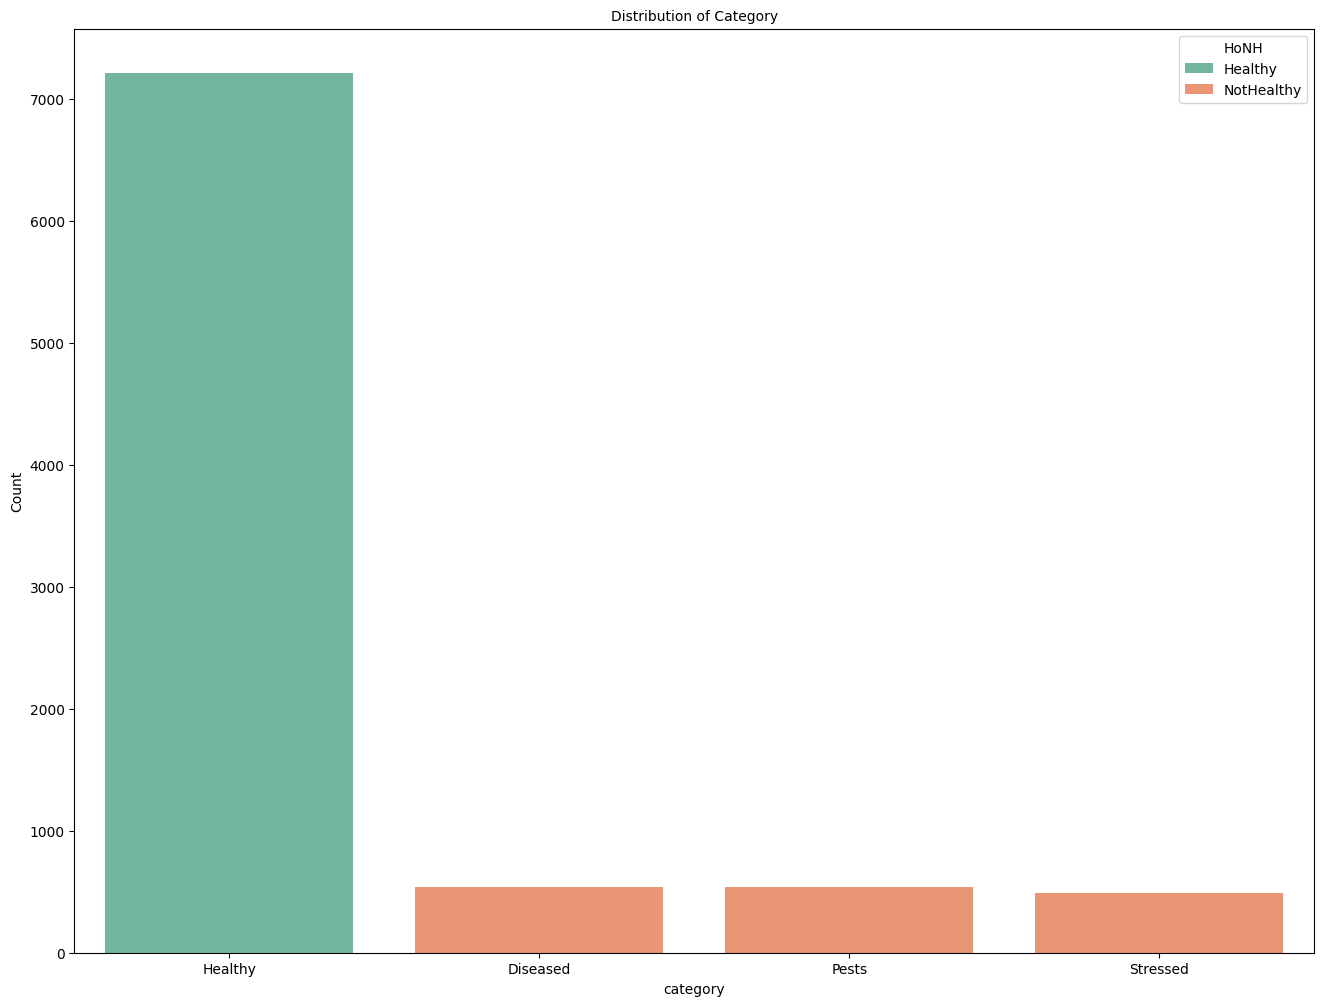

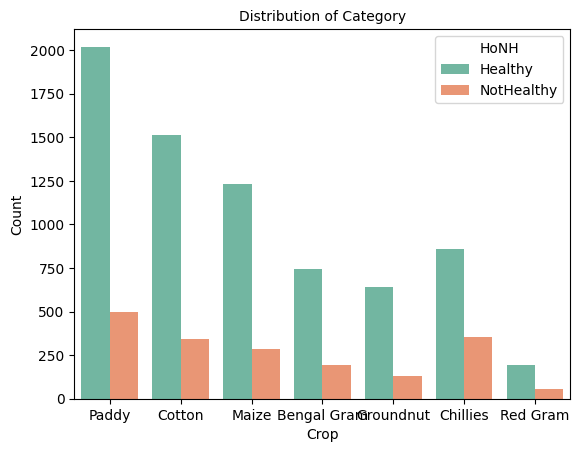

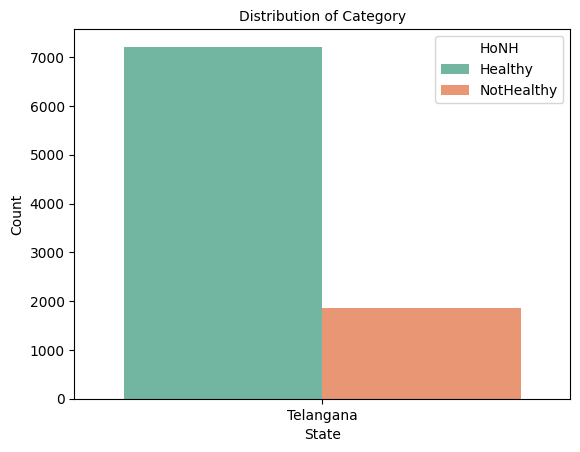

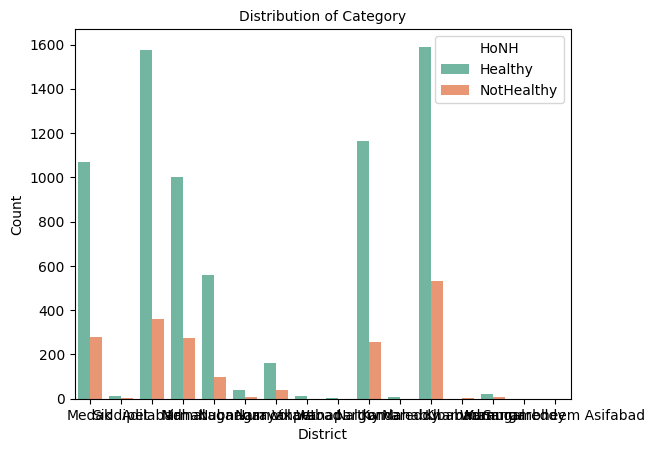

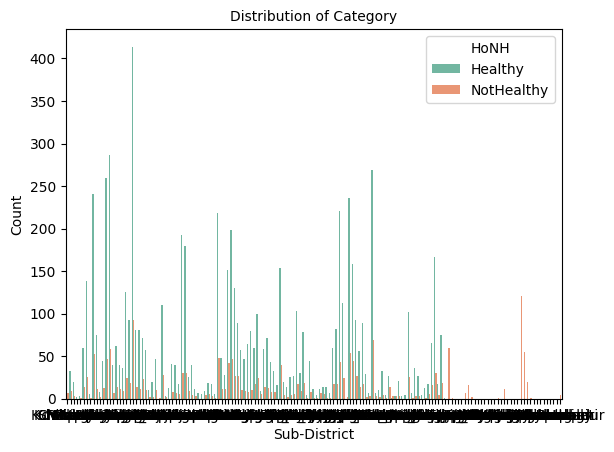

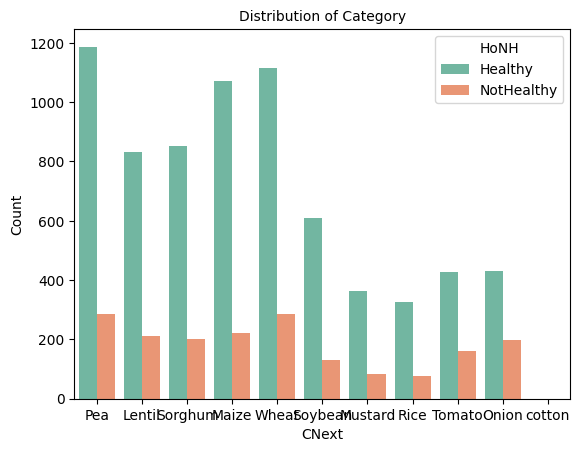

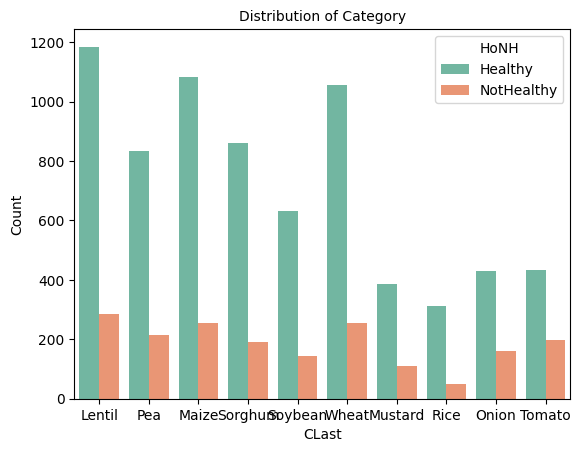

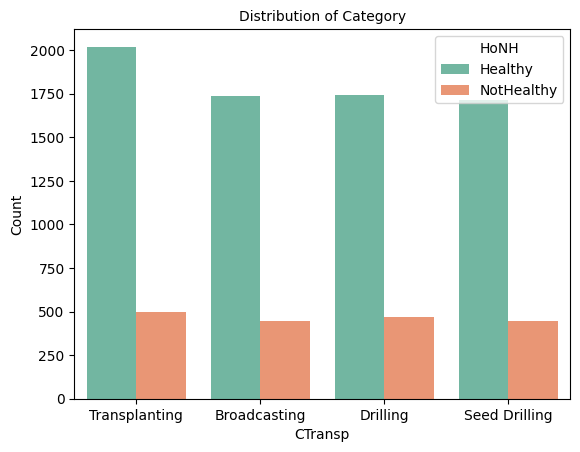

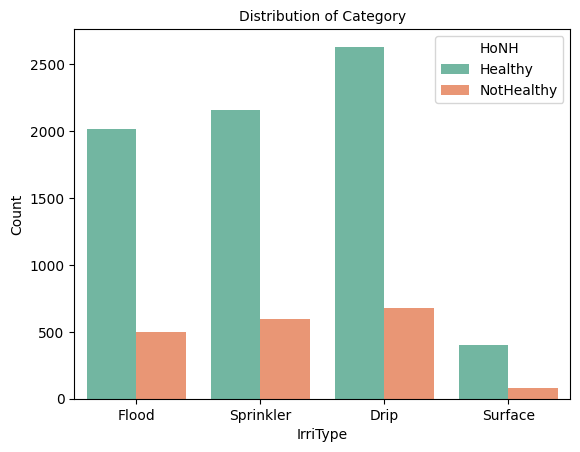

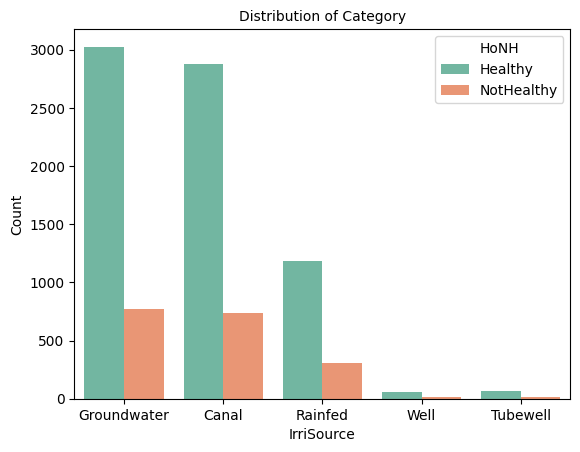

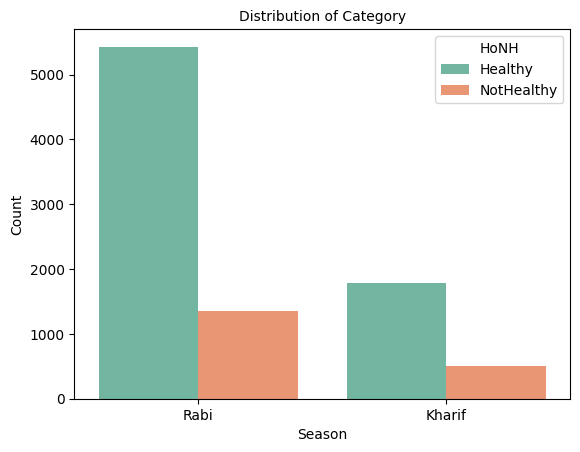

KeyboardInterrupt: 

In [1123]:
import seaborn as sns
import matplotlib.pyplot as plt

# Plot the distribution for each numerical column, grouped by 'HoNH'
plt.figure(figsize=(16, 12))

# for i, col in enumerate(categorical_data.columns, 1):
#     # plt.subplot(len(categorical_data.columns) // 3 + 1, 3, i)
#     sns.countplot(data=categorical_data, x=col, hue='HoNH', palette='Set2')
#     plt.title('Distribution of Category', fontsize=10)
#     plt.xlabel(col)
#     plt.ylabel('Count')
#     plt.show()
sns.countplot(data=categorical_data, x=col, hue='HoNH', palette='Set2')
plt.title('Distribution of Category', fontsize=10)
plt.xlabel(col)
plt.ylabel('Count')
plt.show()


In [1144]:
categorical_cols

['Crop',
 'District',
 'Sub-District',
 'CNext',
 'CLast',
 'CTransp',
 'IrriType',
 'IrriSource',
 'Season',
 'HoNH',
 'grow_time',
 'CNext_type',
 'CLast_type',
 'same_family',
 'legume_to_cereal',
 'cereal_to_legume']

### Impact on NH classifier

In [ ]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import OneHotEncoder, LabelEncoder
from sklearn.impute import SimpleImputer
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, classification_report

# Select categorical columns from training set
encoded_data = categorical_data[categorical_data.dataset == 'train'].drop(columns=['dataset','HoNH']).copy()
categorical_cols = encoded_data.columns.tolist()

for col in categorical_cols:
    unique_vals = encoded_data[col].nunique()
    
    if unique_vals <= 20:
        # One-Hot Encoding for low cardinality categorical columns
        ohe = OneHotEncoder(handle_unknown='ignore', drop='first', sparse_output=False)
        encoded_col = ohe.fit_transform(encoded_data[[col]])
        encoded_col_df = pd.DataFrame(encoded_col, columns=ohe.get_feature_names_out([col]), index=encoded_data.index)
        encoded_data = pd.concat([encoded_data, encoded_col_df], axis=1)
    
    else:
        # Label Encoding for high cardinality categorical columns
        le = LabelEncoder()
        encoded_data[col] = le.fit_transform(encoded_data[col])

# Drop original categorical columns after encoding
encoded_data.drop(columns=categorical_cols, inplace=True)

# Handle missing values
imputer = SimpleImputer(strategy='most_frequent')
X_encoded = pd.DataFrame(imputer.fit_transform(encoded_data), columns=encoded_data.columns)

# Encode target variable
y = LabelEncoder().fit_transform(data[data.dataset == 'train']['HoNH'])

# Train-Test Split (Stratified)
X_train, X_test, y_train, y_test = train_test_split(X_encoded, y, test_size=0.2, stratify=y, random_state=42)

# Train Logistic Regression
model = LogisticRegression(max_iter=1000, random_state=42)
model.fit(X_train, y_train)



Accuracy: 0.8222222222222222
              precision    recall  f1-score   support

           0       0.82      1.00      0.90      1443
           1       0.00      0.00      0.00       312

    accuracy                           0.82      1755
   macro avg       0.41      0.50      0.45      1755
weighted avg       0.68      0.82      0.74      1755



**Consulsion**
- looking at the categorical distribution, results like this are quite expected(healthy always gets the bigger probability)
- Sadly, Oversampling for categorical data doesn't make much sense
- This is why we will end yp not using them for hte NH Classifer

### Impact on binary classification

In [ ]:
inference_data = full_transformed_df[full_transformed_df.FarmID.isin(train.FarmID.values)].dropna(subset=['HoNH']) # data in which we applied yao on train+test features

# Select only numerical features
numerical_cols = full_transformed_df[full_transformed_df.FarmID.isin(train.FarmID.values)].dropna(subset=['HoNH'])
X = inference_data.drop(columns=['HoNH','evi'], errors='ignore').copy()
#inference_data[numerical_cols].drop(columns=['category', 'HoNH'], errors='ignore')  # Drop target if in numerical cols

# Replace infinite values with NaN
X.replace([np.inf, -np.inf], np.nan, inplace=True)

# Impute missing values (replace NaNs with mean)
imputer = SimpleImputer(strategy='mean')
X = imputer.fit_transform(X)

In [1156]:
cat_cols_numed = [
    'grow_time',
    'CNext_type',
    'CLast_type',
    'same_family',
    'legume_to_cereal',
    'cereal_to_legume'
]


In [1170]:

X_concat = pd.concat([X.reset_index(drop=True), categorical_data[categorical_data.dataset=='train'][cat_cols_numed].reset_index(drop=True)], axis=1).dropna()
# Encode target labels ("Healthy" -> 0, "Not Healthy" -> 1)
label_encoder = LabelEncoder()
y = label_encoder.fit_transform(inference_data['HoNH'])


# Split the resampled data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X_concat.drop(columns=['CNext_type', 'CLast_type']), y, test_size=0.2, shuffle=True, random_state=42)

# Print Data Shapes
print(f"Training Shape: {X_train.shape}, Testing Shape: {X_test.shape}")
print(f"Class Distribution (Train): {Counter(y_train)}, Class Distribution (Test): {Counter(y_test)}")


Training Shape: (6310, 38), Testing Shape: (1578, 38)
Class Distribution (Train): Counter({0: 5201, 1: 1109}), Class Distribution (Test): Counter({0: 1305, 1: 273})


In [1171]:
X_concat

,CropCoveredArea,CHeight,IrriCount,WaterCov,ExpYield,ndvi,ndwi,gndvi,savi,msavi,...,range,sum,median,iqr,grow_time,CNext_type,CLast_type,same_family,legume_to_cereal,cereal_to_legume
0,1.453863,-0.700415,0.316617,1.277278,0.317210,-0.770343,-0.827352,-0.354753,-0.774267,0.380970,...,1.326577e+06,4.300096e+06,0.095741,2.154278,141,Legume,Legume,1,0,0
1,0.291947,-0.568561,1.019562,1.492662,-0.004509,-0.109533,0.452477,0.272283,-0.079168,-0.367717,...,1.326578e+06,4.300102e+06,0.282115,1.789399,165,Legume,Legume,1,0,0
2,1.048848,0.272231,-0.409392,1.638090,0.759599,0.005177,-0.172647,0.434124,0.037980,0.023988,...,1.326580e+06,4.300108e+06,0.353177,1.774741,131,Legume,Legume,1,0,0
3,0.969958,-0.769873,1.019562,1.432593,0.159366,0.003100,-0.049139,0.550185,0.035866,-0.028364,...,1.331837e+06,4.317152e+06,0.246586,1.481732,632,Legume,Legume,1,0,0
4,1.208745,-0.666600,1.019562,1.580706,0.759599,-0.163976,-0.764939,0.012658,-0.135097,0.377296,...,1.326580e+06,4.300111e+06,0.251207,1.899059,159,Legume,Legume,1,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
7883,0.009267,0.053381,-1.165425,0.272477,0.469563,2.162445,-2.005610,-2.121147,2.105821,3.423170,...,1.661781e+05,5.386797e+05,1.376095,3.696222,222,Legume,Cereal,0,0,1
7884,0.220193,0.630910,-0.409392,-0.472404,-0.734808,2.177949,-1.919520,-2.136412,2.124296,2.666560,...,1.313291e+06,4.257030e+06,0.795125,3.401368,34,Legume,Cereal,0,0,1
7885,-0.646372,-0.329042,-0.409392,0.183202,-0.175044,-1.167641,-0.151331,-0.704781,-1.209235,-0.230958,...,1.298258e+06,4.208290e+06,-0.280000,1.376977,-100,Legume,Cereal,0,0,1
7886,0.437613,0.469116,-0.409392,-0.101642,0.759599,2.168283,-1.984156,-2.252669,2.112618,3.171454,...,1.323182e+06,4.289095e+06,0.614357,3.803500,-117,Legume,Cereal,0,0,1


In [1172]:
from sklearn.metrics import classification_report
import joblib

# Create an ensemble model using VotingClassifier
ensemble_model = VotingClassifier(estimators=[
    ('logreg', logreg),
    ('rf', rf),
    ('gb', gb),
    # ('svc', svc)
], voting='soft')
ensemble_model.fit(X_train, y_train)
y_prob = ensemble_model.predict_proba(X_test)[:, 1]  # Get probability for class 1



In [1173]:
from sklearn.metrics import f1_score

# Initialize variables to store the best threshold and the best F1 score
best_threshold = 0.30
best_f1_score = 0

# Iterate through thresholds from 0.35 to 0.6 with a step of 0.01
for threshold in np.arange(0.35, 0.61, 0.005):
    # Apply the current threshold
    y_pred = (y_prob > threshold).astype(int)
    
    # Calculate the F1 score
    current_f1_score = f1_score(y_test, y_pred, average='weighted')
    
    # Update the best threshold and F1 score if the current F1 score is better
    if current_f1_score > best_f1_score:
        best_f1_score = current_f1_score
        best_threshold = threshold

# Print the best threshold and the corresponding F1 score
print(f"Best Threshold: {best_threshold}")
print(f"Best F1 Score: {best_f1_score}")

# Apply the best threshold
y_pred = (y_prob > best_threshold).astype(int)

# Print probabilities and actual labels
print(f"Predicted Probabilities:\n{y_prob}")
print(f"Actual Labels:\n{y_test}")

print('f1_score:', f1_score(y_test, y_pred, average='weighted'))

# Evaluate performance
print("\nClassification Report:")
print(classification_report(y_pred, y_test))

Best Threshold: 0.4
Best F1 Score: 0.749729421719765
Predicted Probabilities:
[0.29388495 0.25857967 0.23204322 ... 0.29130773 0.28222983 0.31245781]
Actual Labels:
[1 0 0 ... 0 0 0]
f1_score: 0.749729421719765

Classification Report:
              precision    recall  f1-score   support

           0       0.99      0.83      0.90      1559
           1       0.01      0.21      0.03        19

    accuracy                           0.82      1578
   macro avg       0.50      0.52      0.46      1578
weighted avg       0.98      0.82      0.89      1578



**Conclusion**
- Results arent catastrophic, but including the cat cols, would prevent from the Smote Oversampling on the num columns, because as we said, the categorical columns have specific meaning and oversampling them wouldn't make sense

# End of Notebook
- Feel free to explore other models: Lgbm, xgboost ...
- Feel free to explore some of the image in which we extracted the data.